<a href="https://colab.research.google.com/github/gabrielhribeiro/foodandfeedback/blob/main/Foodriven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install libraries
!pip install demoji
!pip install pyspellchecker
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.6 MB/s eta 0:00:00


In [ ]:
#@title import libraries
import unicodedata as uni
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pandas as pd
import json
from google.colab import drive
import json
import string
import re
import demoji
from keras import models
from keras import layers
import unicodedata as uni
from spellchecker import SpellChecker
import datetime
import nltk
from nltk.corpus import stopwords
import spacy
import ast
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import LdaMulticore
from gensim.models import FastText
import pyLDAvis.gensim_models
import gensim
from pprint import pprint
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
import warnings
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Sample

In [ ]:
#@title Load Google Drive Files
drive.mount('/content/gdrive', force_remount=True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/gdrive


In [ ]:
#@title Read Files from Drive (don't use this section)
data_file_business = open("/content/gdrive/MyDrive/ISEP/yelp_academic_dataset_business.json",mode='r', encoding='utf-8')
data = []

for line in data_file_business:
  data.append(json.loads(line))
business_df = pd.DataFrame(data)
data_file_business.close()

print(business_df.head())

data_file_reviews = open("/content/gdrive/MyDrive/ISEP/yelp_academic_dataset_review.json",mode='r', encoding='utf-8')
data = []

for line in data_file_reviews:
  data.append(json.loads(line))
reviews_df = pd.DataFrame(data)
data_file_reviews.close()

print(reviews_df.head())

In [ ]:
#@title Generate 100 000 lines for sample (Sample already saved in shared drive folder)

#save data at the project3, if exist the file at the folder(Project3), dont run it.
dfyelpnotnull = business_df[business_df['categories'].notna()]
#select just restaurants
dfyelpcleanest = dfyelpnotnull[dfyelpnotnull['categories'].str.contains("Restaurants")]

dfyelp = pd.merge(reviews_df, dfyelpcleanest, on=['business_id','business_id'])
dfyelpnotnull = dfyelp[dfyelp['categories'].notna()]


samples_per_rating_negative = 50000 // 3
samples_per_rating_positive = 50000 // 2
sampled_df = pd.DataFrame()

# Extract an equal number of samples for each rating
for rating in range(1, 6):
  if(rating < 4):
    samples = dfyelpnotnull[dfyelpnotnull['stars_x'] == rating].sample(samples_per_rating_negative, random_state=42)
    sampled_df = sampled_df.append(samples, ignore_index=True)
  else:
    samples = dfyelpnotnull[dfyelpnotnull['stars_x'] == rating].sample(samples_per_rating_positive, random_state=42)
    sampled_df = sampled_df.append(samples, ignore_index=True)

# Shuffle the sampled DataFrame
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
rating_counts = sampled_df['stars_x'].value_counts()
print(rating_counts)

sampled_df.to_csv('/content/gdrive/MyDrive/ISEP/Projeto3/cleaned100000reviews.csv',index=False)

In [ ]:
#@title Load sample reviews(Start by here)

drive.mount('/content/gdrive', force_remount=True)

dfyelp = pd.read_csv('/content/gdrive/MyDrive/ISEP/Projeto3/cleaned100000reviews.csv')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/gdrive


In [ ]:
#@title remove unnecessary columns
dfyelp = dfyelp.drop(columns=["funny","cool","address","postal_code","latitude","longitude","is_open","attributes","hours"])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dfyelp.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,review_id,user_id,business_id,stars_x,useful,text,date,name,city,state,stars_y,review_count,categories
0,5-zzokZW6svDyMDKietY0w,5uPjvkBCsJOg4kfhE9xg3A,MK0OMY_u9unl8xSqjPLtMw,4.0,0,I had never heard of Seis until a friend sugge...,2015-02-26 00:22:18,Seis Kitchen,Tucson,AZ,4.5,661,"Street Vendors, Nightlife, Food, Bars, Food Tr..."
1,AsXDPASkJmq1Y3ji7dKvyw,EM5lGVk4t-c6vtgkrpxD_A,5s7I0Khg7ReVzfO7niJtKg,4.0,2,I've never really had Mediterranean food befor...,2017-04-14 04:15:58,Zayna Mediterranean,Tucson,AZ,4.5,602,"Syrian, Mediterranean, Middle Eastern, Restaur..."
2,cdnPUQ5xom0aO2hN7-2CRQ,kWrmTf5LSTy2v83aM_xy1g,JcdOQvvx3BqZ5Ga2_9n_Bg,2.0,3,I have been to other Joeys and they were much ...,2017-01-22 17:00:51,JOEY Mayfield,Edmonton,AB,4.0,70,"American (Traditional), Lounges, Bars, Restaur..."
3,LpdAGrXHQUPFpTZHOkb5Cg,ZG8HfqHHnrMQ6QMkpRZlLw,5V_juhi6tZxcyFclSe8fDg,2.0,1,Food is usually pretty good but the service to...,2015-08-22 19:14:10,Panda Express,Fairview Heights,IL,3.0,16,"Fast Food, Chinese, Restaurants"
4,DiQ2C7hmGLHs_v95IQc1dA,ml1AQElm3F1QCb0a6AJiKQ,MMs3kznm5GqTlie0vTnYzg,1.0,0,"I came here to try the food, after I had picke...",2018-09-18 01:31:45,Antney's Grub,Philadelphia,PA,3.5,19,"Restaurants, Italian, Sandwiches, American (New)"


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 2500x2000 with 0 Axes>

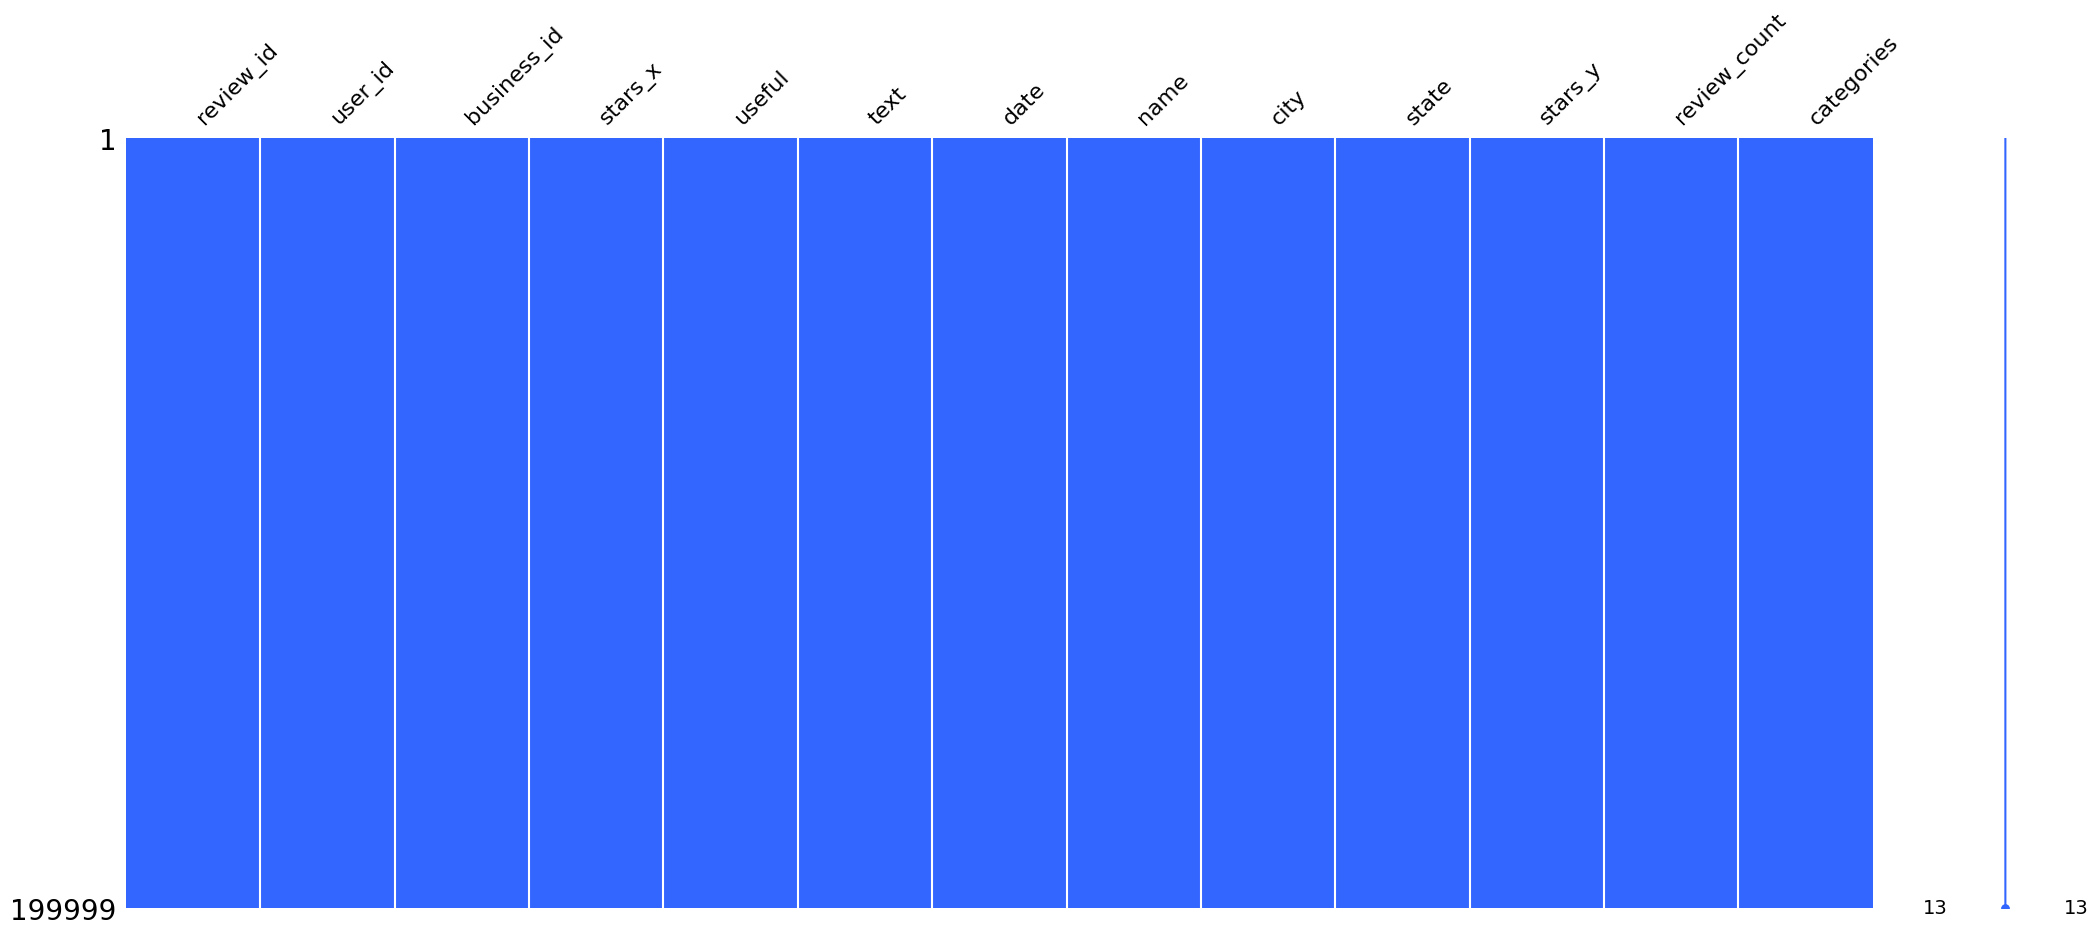

In [ ]:
#identify missing information

plt.figure(figsize=(25, 20))
msno.matrix(dfyelp, color=[0.2, 0.4, 1])
plt.show()

In [ ]:
dfyelp.dropna(inplace=True, axis=0)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Explore - Data Analysis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


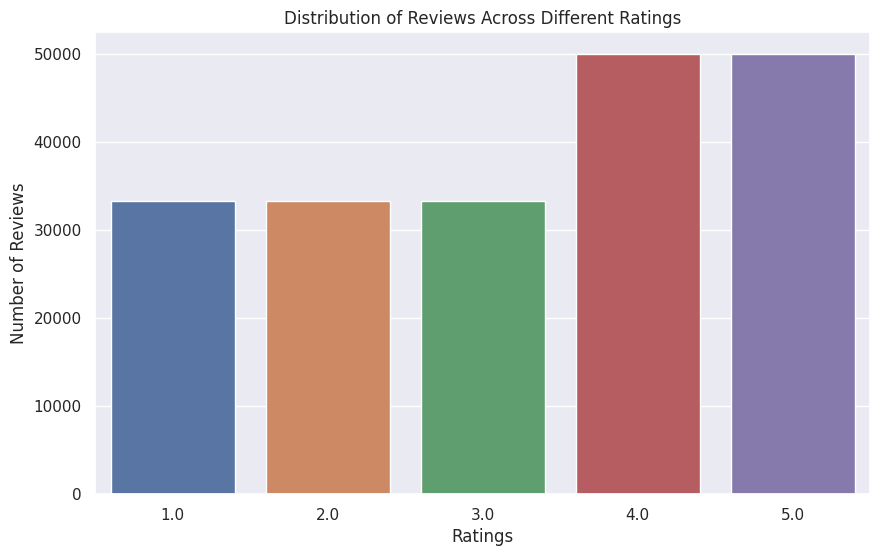

In [ ]:
#@title Number of Reviews per Rating
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=dfyelp, x='stars_x')
ax.set_title('Distribution of Reviews Across Different Ratings')
ax.set_xlabel('Ratings')
ax.set_ylabel('Number of Reviews')
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


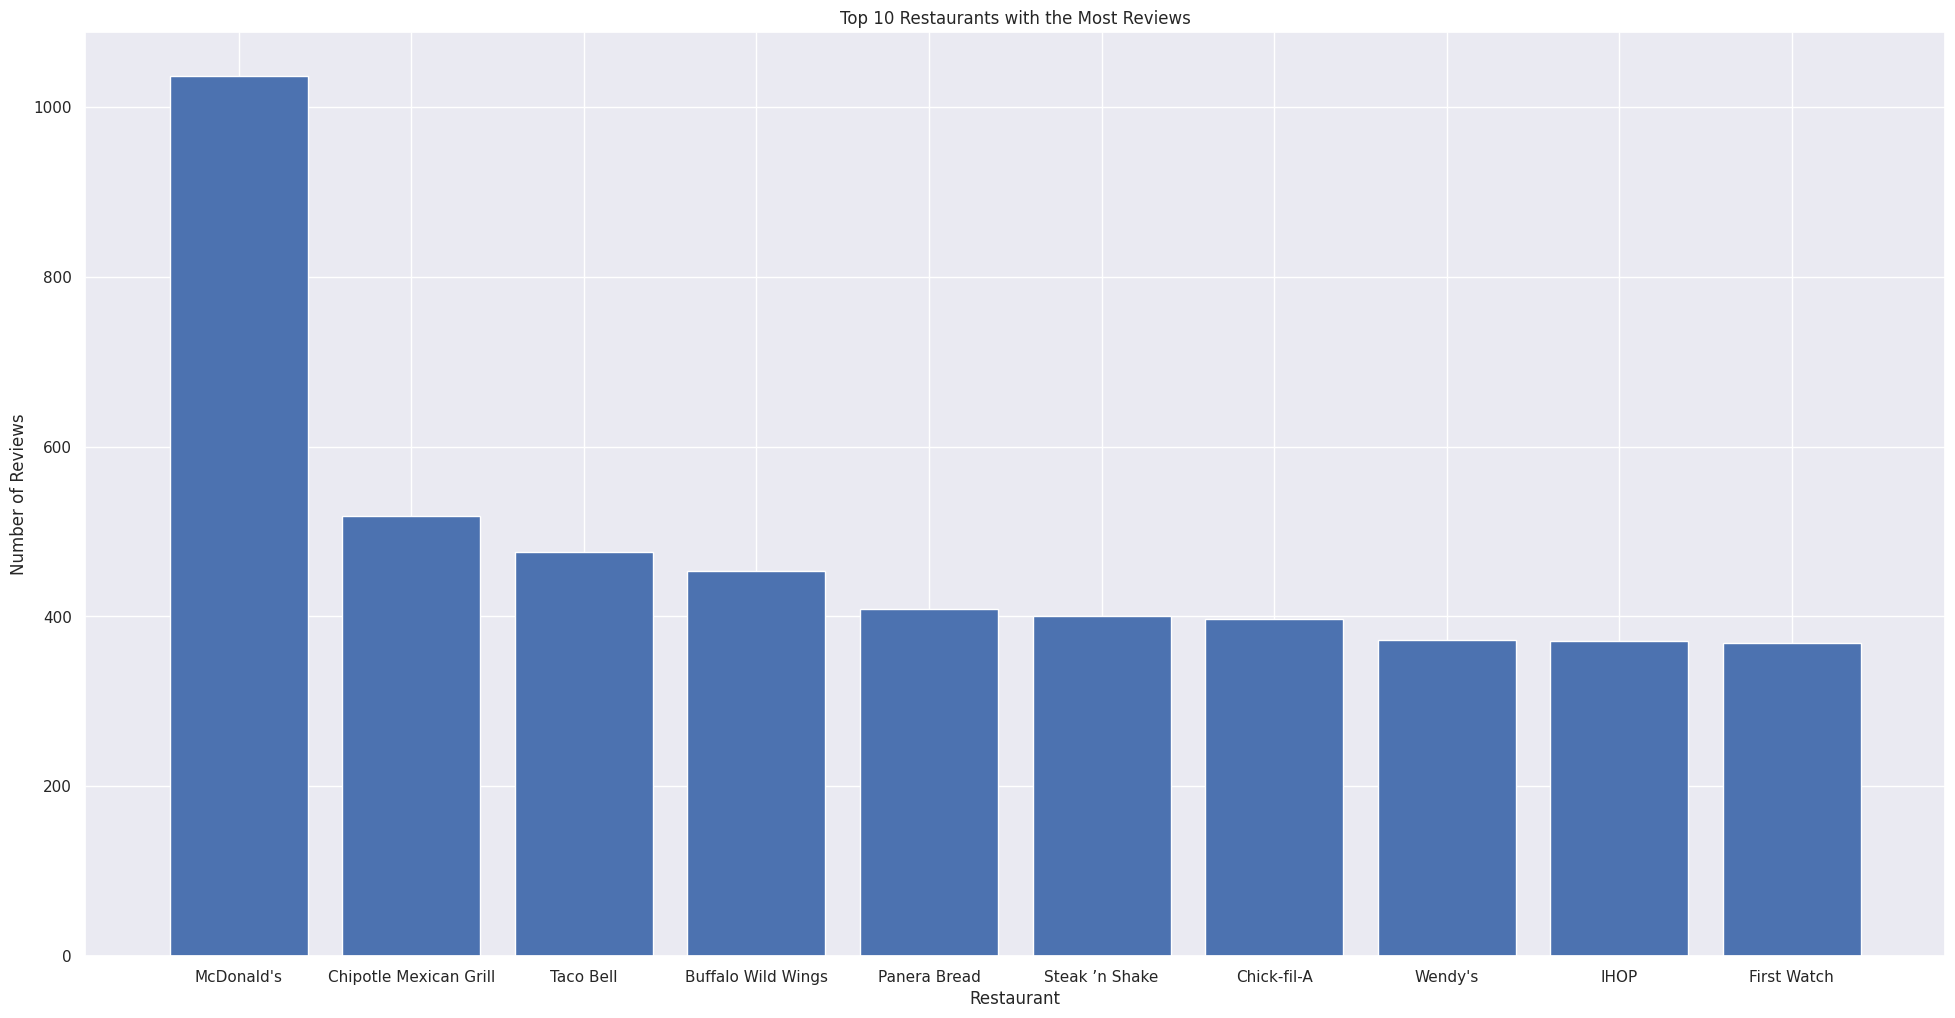

In [ ]:
#@title Top 10 restaurants with most reviews

restaurant_counts = dfyelp['name'].value_counts()

# Get the top 10 cities with the most reviews
top_restaurants = restaurant_counts.nlargest(10)

# Plot the bar graph
plt.figure(figsize=(24, 12))
plt.bar(top_restaurants.index, top_restaurants.values)
plt.xlabel('Restaurant')
plt.ylabel('Number of Reviews')
plt.title('Top 10 Restaurants with the Most Reviews')
plt.show()

In [ ]:
print(dfyelp['name'].nunique())

27011


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


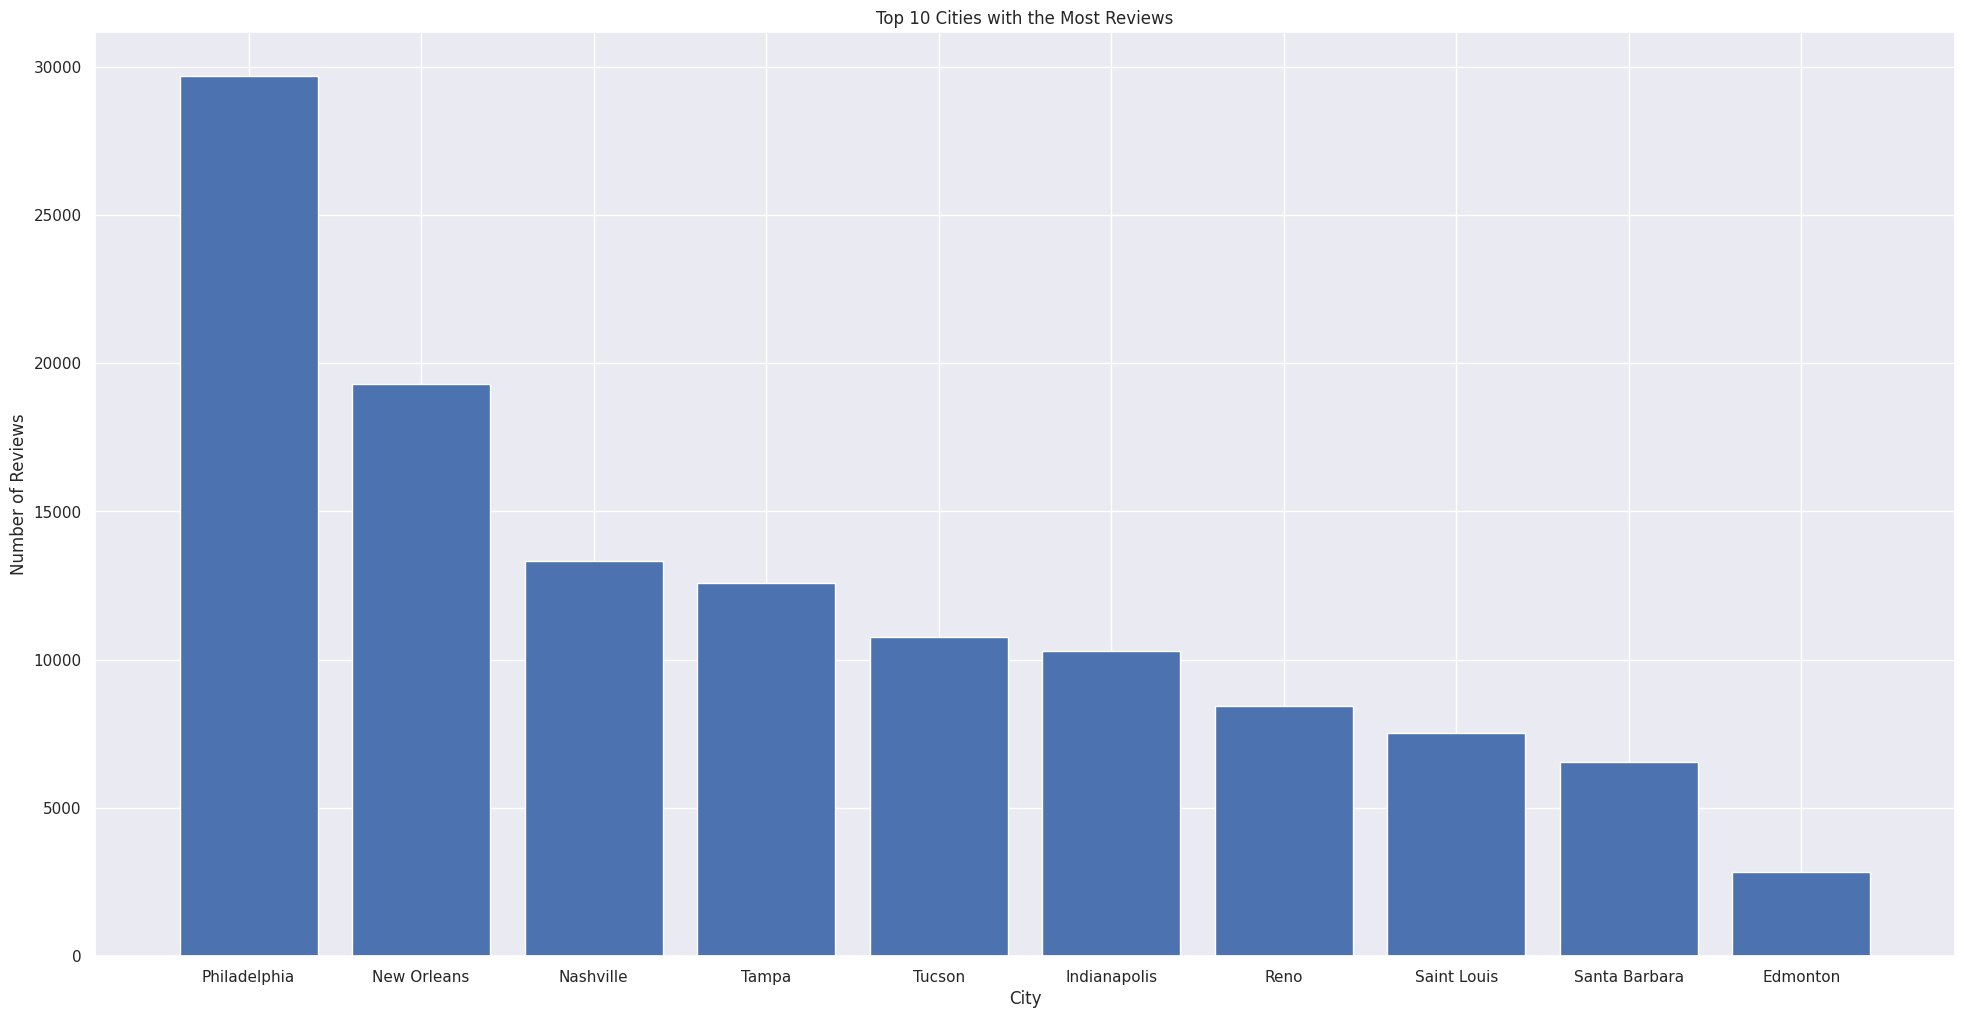

In [ ]:
#@title Top 10 cities with most reviews

city_counts = dfyelp['city'].value_counts()

# Get the top 10 cities with the most reviews
top_cities = city_counts.nlargest(10)

# Plot the bar graph
plt.figure(figsize=(24, 12))
plt.bar(top_cities.index, top_cities.values)
plt.xlabel('City')
plt.ylabel('Number of Reviews')
plt.title('Top 10 Cities with the Most Reviews')
plt.show()

In [ ]:
print(dfyelp['city'].nunique())

802


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Modify - Text Cleaning

In [ ]:
#@title Remove URLs


def remove_url(text):
    text = re.sub(r"http\S+", "", text)
    return text

dfyelp['text'] = dfyelp['text'].apply(remove_url)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Unicode Normalization

def uniNormalize(text):
      return uni.normalize('NFKD',text)

dfyelp['text'] = dfyelp['text'].apply(uniNormalize)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Handle Emojis

def handle_emoji(string):
    emojis = demoji.findall(string)
    return " ".join([emojis[emoji].split(":")[0] for emoji in emojis]) if emojis else string
dfyelp['text'] = dfyelp['text'].apply(handle_emoji)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Spelling Correction

spell = SpellChecker()

def correct_spelling(text):
    tokens = re.findall(r"[\w']+|[.,!?;]", text)
    corrected_tokens = []
    for token in tokens:
        if token.isalnum():
            corrected_token = spell.correction(token)
            corrected_tokens.append(corrected_token if corrected_token is not None else token)
        else:
            corrected_tokens.append(token)
    corrected_text = " ".join(corrected_tokens)
    return corrected_text

dfyelp['text'] = dfyelp['text'].apply(correct_spelling)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Save text cleaned dataframe to drive
dfyelp.to_csv('/content/gdrive/MyDrive/ISEP/Projeto3/textCleanedSample.csv',index=False)

# Modify- Text Preprocessing

In [ ]:
#@title Load text cleaned sample
drive.mount('/content/gdrive', force_remount=True)

dfyelp = pd.read_csv('/content/gdrive/MyDrive/ISEP/Projeto3/textCleanedSample.csv')

In [ ]:
print(dfyelp.isna().sum())
dfyelp.dropna(inplace=True, axis=0)

In [ ]:
#@title Sentences and words Tokenizer

def tokenize_review(review):
    sentences = nltk.sent_tokenize(review)
    words = [nltk.word_tokenize(sentence) for sentence in sentences]
    return words

dfyelp['preprocessed_text'] = dfyelp['text'].apply(tokenize_review)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Removing stop words

from nltk.corpus import stopwords

def remove_stop_words(tokenized_text):
    stop_words = set(stopwords.words('english'))
    cleaned_text = []
    for sentence in tokenized_text:
        cleaned_sentence = []
        for word in sentence:
            if word.lower() not in stop_words:
                # Remove "'s" suffix if present
                if word.endswith("'s"):
                    cleaned_word = ""
                elif word.endswith("'t"):
                    cleaned_word = ""
                elif word.endswith("\'s"):
                    cleaned_word = ""
                else:
                    cleaned_word = word
                if word != "":
                  cleaned_sentence.append(cleaned_word)
        cleaned_text.append(cleaned_sentence)
    return cleaned_text

dfyelp['preprocessed_text'] = dfyelp['preprocessed_text'].apply(remove_stop_words)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Turn text to lowercase
def lowercase_words(words):
    return [word.lower() for word in words]

dfyelp['preprocessed_text'] = dfyelp['preprocessed_text'].apply(lambda x: [lowercase_words(sentence) for sentence in x])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Remove punctuation
def remove_punctuation(tokenized_reviews):
    cleaned_reviews = [word for word in tokenized_reviews if (word not in string.punctuation) and ('\\' not in word) and ('""' not in word)]
    return cleaned_reviews

dfyelp['preprocessed_text'] = dfyelp['preprocessed_text'].apply(lambda x: [remove_punctuation(sentence) for sentence in x])
dfyelp['preprocessed_text']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Stemming (We decided to use Lemmatizer instead)
#Utilized snowball stemmer as it's more modern
def stem_words(tokenized_words):
    stemmer = SnowballStemmer('english')
    stemmed_words = [
        stemmer.stem(word) for word in tokenized_words
    ]
    return stemmed_words

dfyelp['preprocessed_text'] = dfyelp['preprocessed_text'].apply(lambda x: [stem_words(sentence) for sentence in x])
dfyelp['preprocessed_text']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Lemmatizer

nlp = spacy.load('en_core_web_sm')

def lemmatize_words(words):
    text = " ".join(words)
    token = nlp(text)
    text = [word.lemma_ for word in token]
    return text
tqdm.pandas()

# apply lemmatization to "text" column
dfyelp['preprocessed_text'] = dfyelp['preprocessed_text'].progress_map(lambda x: [lemmatize_words(sentence) for sentence in x])

dfyelp['preprocessed_text']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Convert ratings to positive or negative
convert_rating = lambda x: 1 if x >= 4 else 0

# Apply the function to the 'rating' column and store the result in a new column called 'new_rating'
dfyelp['rating'] = dfyelp['stars_x'].apply(convert_rating)

In [ ]:
#@title Clean text column
def flatten_and_join(lst):
    return ' '.join([word for sublist in lst for word in sublist])

dfyelp['clean_text'] = dfyelp['preprocessed_text'].apply(flatten_and_join)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Remove non essential columns
dfyelp = dfyelp.drop(columns=["review_id","user_id","business_id","useful","date","name","city","state","stars_y","stars_x","review_count","categories"])

In [ ]:
#@title Save preprocessed text dataframe to drive
dfyelp.to_csv('/content/gdrive/MyDrive/ISEP/Projeto3/textPreProcessedSample.csv',index=False)

In [ ]:
#@title Load preprocessed text dataframe from drive
drive.mount('/content/gdrive', force_remount=True)

dfyelp = pd.read_csv('/content/gdrive/MyDrive/ISEP/Projeto3/textPreProcessedSample.csv')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/gdrive


In [ ]:
#@title Analyzing LDA model - Latent Dirichlet allocation
#https://www.analyticssteps.com/blogs/what-latent-dirichlet-allocation-lda-nlp
import pandas as pd

data = []

# Iterate over each row of the data column
for row in dfyelp.preprocessed_text:
    words = row.strip('][').split(', ')
    words = [w.strip("'[]") for w in words]
    data.append(words)


dictionarydfyelp = corpora.Dictionary(data)
corpus = [dictionarydfyelp.doc2bow(doc) for doc in data]

# train an LDA model on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionarydfyelp, num_topics=10, passes=15,iterations=400)

#print the top words in each topic
pprint(lda_model.show_topics())

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.055*"order" + 0.040*"wait" + 0.034*"minute" + 0.033*"food" + 0.030*"get" '
  '+ 0.022*"take" + 0.022*"service" + 0.020*"go" + 0.018*"time" + '
  '0.015*"customer"'),
 (1,
  '0.032*"roll" + 0.025*"sushi" + 0.021*"dish" + 0.020*"soup" + 0.018*"rice" + '
  '0.016*"chicken" + 0.013*"noodle" + 0.012*"spicy" + 0.012*"thai" + '
  '0.011*"bowl"'),
 (2,
  '0.040*"bar" + 0.039*"beer" + 0.030*"great" + 0.030*"drink" + 0.024*"night" '
  '+ 0.021*"wine" + 0.016*"good" + 0.015*"bartender" + 0.014*"happy" + '
  '0.013*"dinner"'),
 (3,
  '0.014*"we" + 0.013*"table" + 0.013*"food" + 0.012*"come" + 0.011*"go" + '
  '0.011*"would" + 0.010*"one" + 0.010*"time" + 0.010*"get" + '
  '0.009*"restaurant"'),
 (4,
  '0.049*""\'"" + 0.026*"ve" + 0.022*"m" + 0.021*"pizza" + 0.021*"place" + '
  '0.019*"good" + 0.018*"go" + 0.017*"get" + 0.016*"time" + 0.015*"like"'),
 (5,
  '0.059*"food" + 0.048*"great" + 0.041*"good" + 0.034*"service" + '
  '0.033*"place" + 0.017*"friendly" + 0.017*"love" + 0.017*"go" + 

In [ ]:
#@title Analyzing LDA model results

# create the visualization
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionarydfyelp, sort_topics=False)

# display the visualization
pyLDAvis.display(lda_display)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
#@title Creating Similarity Matrix
#can help to uncover patterns and relationships within a dataset,
fasttext_model = FastText(data, vector_size= 100, window=5, min_count=5, workers=4,sg=1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Adding similary for each aspect
aspects = ["service", "food","location","order","price","staff","menu","experience","taste","drink"]

def get_similarity(text, aspect):
    try:
        text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0

tqdm.pandas()
for aspect in aspects:
    dfyelp[aspect] = dfyelp['preprocessed_text'].progress_map(lambda text: get_similarity(text, aspect))

In [ ]:
dfyelp.head()

In [ ]:
#@title Save dataframe with similarity to drive
dfyelp.to_csv('/content/gdrive/MyDrive/ISEP/Projeto3/textSimilaritySample.csv',index=False)

# Model

In [ ]:
#@title Load aspect similarity dataframe from drive
drive.mount('/content/gdrive', force_remount=True)

dfyelp = pd.read_csv('/content/gdrive/MyDrive/ISEP/Projeto3/textSimilaritySample.csv')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/gdrive


In [ ]:
dfyelp.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,preprocessed_text,rating,clean_text,service,food,location,order,price,staff,menu,experience,taste,drink
0,I really like this place it is very small and ...,"[['really', 'like', 'place', 'small', 'comfort...",0,really like place small comfortable dinning se...,0.729840,0.435061,0.717543,0.694251,0.703085,0.513394,0.715437,0.706248,0.733615,0.652292
1,I expected more from this place . For how much...,"[['expect', 'place'], ['much', 'food', 'leave'...",0,expect place much food leave lot desire taste ...,0.694164,0.410856,0.685354,0.654796,0.667010,0.512929,0.674312,0.657457,0.714819,0.611897
2,Everyone in the freakin nation kept telling me...,"[['everyone', 'freakin', 'nation', 'keep', 'te...",0,everyone freakin nation keep tell place try 3 ...,0.712353,0.411931,0.711553,0.669426,0.686846,0.508796,0.703556,0.690123,0.722762,0.634415
3,I have gone to plenty of Mexican stores to say...,"[['go', 'plenty', 'mexican', 'store', 'say', '...",0,go plenty mexican store say one abusive price ...,0.728700,0.408487,0.704595,0.682020,0.699338,0.508350,0.708221,0.703036,0.734015,0.631041
4,I was just in Little Greek and saw the cash re...,"[['little', 'greek', 'see', 'cash', 'register'...",0,little greek see cash register employee make m...,0.744959,0.459193,0.748439,0.714634,0.720313,0.544003,0.725237,0.702268,0.754001,0.681421


In [ ]:
dfyelp.columns = dfyelp.columns.str.replace('rating', 'y')

dfyelp

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,preprocessed_text,y,clean_text,service,food,location,order,price,staff,menu,experience,taste,drink
0,I really like this place it is very small and ...,"[['really', 'like', 'place', 'small', 'comfort...",0,really like place small comfortable dinning se...,0.729840,0.435061,0.717543,0.694251,0.703085,0.513394,0.715437,0.706248,0.733615,0.652292
1,I expected more from this place . For how much...,"[['expect', 'place'], ['much', 'food', 'leave'...",0,expect place much food leave lot desire taste ...,0.694164,0.410856,0.685354,0.654796,0.667010,0.512929,0.674312,0.657457,0.714819,0.611897
2,Everyone in the freakin nation kept telling me...,"[['everyone', 'freakin', 'nation', 'keep', 'te...",0,everyone freakin nation keep tell place try 3 ...,0.712353,0.411931,0.711553,0.669426,0.686846,0.508796,0.703556,0.690123,0.722762,0.634415
3,I have gone to plenty of Mexican stores to say...,"[['go', 'plenty', 'mexican', 'store', 'say', '...",0,go plenty mexican store say one abusive price ...,0.728700,0.408487,0.704595,0.682020,0.699338,0.508350,0.708221,0.703036,0.734015,0.631041
4,I was just in Little Greek and saw the cash re...,"[['little', 'greek', 'see', 'cash', 'register'...",0,little greek see cash register employee make m...,0.744959,0.459193,0.748439,0.714634,0.720313,0.544003,0.725237,0.702268,0.754001,0.681421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,Service was terrible it was not crowded at all...,"[['service', 'terrible', 'crowd', 'still', 'wa...",0,service terrible crowd still wait 15 minute an...,0.721246,0.461272,0.719279,0.702243,0.702847,0.514809,0.703537,0.694739,0.712184,0.668402
99994,A couple of appetizers . The entertainment sin...,"[['couple', 'appetizer'], ['entertainment', 's...",1,couple appetizer entertainment singer rise bil...,0.770656,0.454150,0.757254,0.734530,0.747432,0.537614,0.769694,0.765753,0.757360,0.690367
99995,"Came down for Mardi Gras , I have never ate th...","[['come', 'mardi', 'gras', 'never', 'eat', 'cr...",1,come mardi gras never eat crawfish ' m jersey ...,0.703508,0.424302,0.713761,0.672016,0.680306,0.529460,0.700654,0.670128,0.728753,0.641998
99996,I asked the bartender how much bottled beer wa...,"[['ask', 'bartender', 'much', 'bottled', 'beer...",0,ask bartender much bottled beer say 2 50 end n...,0.714352,0.418026,0.718639,0.692387,0.693830,0.531064,0.704106,0.687682,0.740275,0.646148


In [ ]:
#@title model configuration

class config:
    warnings.filterwarnings("ignore", category = UserWarning)
    DEVICE = ("cuda" if torch.cuda.is_available() else "cpu") # where the model will use the processing
    FOLDS = 20 #number os cross validation
    SHUFFLE = True # randomize the values to increase the fitting
    BATCH_SIZE = 32
    LR = 0.1
    EPOCHS = 20
    EMB_DIM = 100 #every word will use a 100 size vector
    MAX_LEN = 20
    MODEL_PATH = "./Models/MyModel.pt"

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#converting text data into numerical form, and creating batches of numericalized text data for training
class Vocabulary:

    '''
    __init__ method is called by default as soon as an object of this class is initiated
    we use this method to initiate our vocab dictionaries
    '''
    def __init__(self, freq_threshold, max_size):
        '''
        freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
        max_size : max source vocab size. Eg. if set to 10,000, we pick the top 10,000 most frequent words and discard others
        '''
        #initiate the index to token dict
        ## <PAD> -> padding, used for padding the shorter sentences in a batch to match the length of longest sentence in the batch
        ## <SOS> -> start token, added in front of each sentence to signify the start of sentence
        ## <EOS> -> End of sentence token, added to the end of each sentence to signify the end of sentence
        ## <UNK> -> words which are not found in the vocab are replace by this token
        self.itos = {0: '<PAD>', 1:'<SOS>', 2:'<EOS>', 3: '<UNK>'}
        #initiate the token to index dict
        self.stoi = {k:j for j,k in self.itos.items()}

        self.freq_threshold = freq_threshold
        self.max_size = max_size

    '''
    __len__ is used by dataloader later to create batches
    '''
    def __len__(self):
        return len(self.itos)

    '''
    a simple tokenizer to split on space and converts the sentence to list of words
    '''
    @staticmethod
    def tokenizer(text):
        return [tok.lower().strip() for tok in text.split(' ')]

    '''
    build the vocab: create a dictionary mapping of index to string (itos) and string to index (stoi)
    output ex. for stoi -> {'the':5, 'a':6, 'an':7}
    '''
    def build_vocabulary(self, sentence_list):
        #calculate the frequencies of each word first to remove the words with freq < freq_threshold
        frequencies = {}  #init the freq dict
        idx = 4 #index from which we want our dict to start. We already used 4 indexes for pad, start, end, unk

        #calculate freq of words
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                if word not in frequencies.keys():
                    frequencies[word]=1
                else:
                    frequencies[word]+=1


        #limit vocab by removing low freq words
        frequencies = {k:v for k,v in frequencies.items() if v>self.freq_threshold}

        #limit vocab to the max_size specified
        frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-idx])

        #create vocab
        for word in frequencies.keys():
            self.stoi[word] = idx
            self.itos[idx] = word
            idx+=1

    '''
    convert the list of words to a list of corresponding indexes
    '''
    def numericalize(self, text):
        #tokenize text
        tokenized_text = self.tokenizer(text)
        numericalized_text = []
        for token in tokenized_text:
            if token in self.stoi.keys():
                numericalized_text.append(self.stoi[token])
            else: #out-of-vocab words are represented by UNK token index
                numericalized_text.append(self.stoi['<UNK>'])

        return numericalized_text

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    '''
    Initiating Variables
    df: the training dataframe
    source_column : the name of source text column in the dataframe
    transform : If we want to add any augmentation
    freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
    source_vocab_max_size : max source vocab size
    '''

    def __init__(self, df, source_column,freq_threshold = 3,
                source_vocab_max_size = 10000 ):

        self.df = df
        #get source and target texts
        self.source_texts = self.df[source_column]


        ##VOCAB class has been created above
        #Initialize source vocab object and build vocabulary
        self.source_vocab = Vocabulary(freq_threshold, source_vocab_max_size)
        self.source_vocab.build_vocabulary(self.source_texts.tolist())


    def __len__(self):
        return len(self.df)

    '''
    __getitem__ runs on 1 example at a time. Here, we get an example at index and return its numericalize source and
    target values using the vocabulary objects we created in __init__
    '''
    def __getitem__(self, index):
        source_text = self.source_texts[index]

        #numericalize texts ['<SOS>','cat', 'in', 'a', 'bag','<EOS>'] -> [1,12,2,9,24,2]
        numerialized_source = [self.source_vocab.stoi["<SOS>"]]
        numerialized_source += self.source_vocab.numericalize(source_text)
        numerialized_source.append(self.source_vocab.stoi["<EOS>"])

        #convert the list to tensor and return
        return torch.tensor(numerialized_source), torch.tensor(self.df.y[index])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_emb_layer_with_weights(target_vocab, emb_model, trainable = False):

    weights_matrix = np.zeros((len(target_vocab), config.EMB_DIM))
    words_found = 0

    for i, word in enumerate(target_vocab):
        weights_matrix[i] = np.concatenate([emb_model.wv[word]])
        words_found += 1

    print(f"Words found are : {words_found}")

    weights_matrix = torch.tensor(weights_matrix, dtype = torch.float32).reshape(len(target_vocab), config.EMB_DIM)
    emb_layer = nn.Embedding.from_pretrained(weights_matrix)
    print(emb_layer)
    if trainable:
        emb_layer.weight.requires_grad = True
    else:
        emb_layer.weight.requires_grad = False

    return emb_layer

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#This is a class called MyCollate which defines how to collate or group data samples into batches during training

class MyCollate:
    def __init__(self, pad_idx, maxlen):
        self.pad_idx = pad_idx
        self.maxlen = maxlen


    #__call__: a default method
    ##   First the obj is created using MyCollate(pad_idx) in data loader
    ##   Then if obj(batch) is called -> __call__ runs by default
    def __call__(self, batch):
        #get all source indexed sentences of the batch
        source = [item[0] for item in batch]

        padded_sequence = torch.zeros((self.maxlen, len(batch)), dtype = torch.int)

        for idx, text in enumerate(source):

            if len(text) > self.maxlen:
                padded_sequence[:, idx] = source[idx][: self.maxlen]
            else:
                padded_sequence[:len(source[idx]), idx] = padded_sequence[:len(source[idx]), idx] + source[idx]


        #get all target indexed sentences of the batch
        target = [item[1] for item in batch]

        target = torch.tensor(target, dtype = torch.float32).reshape(-1)
        return padded_sequence, target

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dfyelp = dfyelp.dropna(subset=["clean_text"]).reset_index(drop=True)
dataset = CustomDataset(dfyelp, "clean_text")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(dataset.source_vocab.stoi)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10000

In [ ]:
dfyelp

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,preprocessed_text,y,clean_text,service,food,location,order,price,staff,menu,experience,taste,drink
0,I really like this place it is very small and ...,"[['really', 'like', 'place', 'small', 'comfort...",0,really like place small comfortable dinning se...,0.729840,0.435061,0.717543,0.694251,0.703085,0.513394,0.715437,0.706248,0.733615,0.652292
1,I expected more from this place . For how much...,"[['expect', 'place'], ['much', 'food', 'leave'...",0,expect place much food leave lot desire taste ...,0.694164,0.410856,0.685354,0.654796,0.667010,0.512929,0.674312,0.657457,0.714819,0.611897
2,Everyone in the freakin nation kept telling me...,"[['everyone', 'freakin', 'nation', 'keep', 'te...",0,everyone freakin nation keep tell place try 3 ...,0.712353,0.411931,0.711553,0.669426,0.686846,0.508796,0.703556,0.690123,0.722762,0.634415
3,I have gone to plenty of Mexican stores to say...,"[['go', 'plenty', 'mexican', 'store', 'say', '...",0,go plenty mexican store say one abusive price ...,0.728700,0.408487,0.704595,0.682020,0.699338,0.508350,0.708221,0.703036,0.734015,0.631041
4,I was just in Little Greek and saw the cash re...,"[['little', 'greek', 'see', 'cash', 'register'...",0,little greek see cash register employee make m...,0.744959,0.459193,0.748439,0.714634,0.720313,0.544003,0.725237,0.702268,0.754001,0.681421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,Service was terrible it was not crowded at all...,"[['service', 'terrible', 'crowd', 'still', 'wa...",0,service terrible crowd still wait 15 minute an...,0.721246,0.461272,0.719279,0.702243,0.702847,0.514809,0.703537,0.694739,0.712184,0.668402
99992,A couple of appetizers . The entertainment sin...,"[['couple', 'appetizer'], ['entertainment', 's...",1,couple appetizer entertainment singer rise bil...,0.770656,0.454150,0.757254,0.734530,0.747432,0.537614,0.769694,0.765753,0.757360,0.690367
99993,"Came down for Mardi Gras , I have never ate th...","[['come', 'mardi', 'gras', 'never', 'eat', 'cr...",1,come mardi gras never eat crawfish ' m jersey ...,0.703508,0.424302,0.713761,0.672016,0.680306,0.529460,0.700654,0.670128,0.728753,0.641998
99994,I asked the bartender how much bottled beer wa...,"[['ask', 'bartender', 'much', 'bottled', 'beer...",0,ask bartender much bottled beer say 2 50 end n...,0.714352,0.418026,0.718639,0.692387,0.693830,0.531064,0.704106,0.687682,0.740275,0.646148


In [ ]:
#@title Initializing the Model
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, embedding_layer):
        super().__init__()
#         self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.hidden_dim = hidden_dim
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True) #The bidirectional parameter is an optional parameter that can be set to True or False. If set to True, the LSTM will process the input data in both forward and backward directions, effectively doubling the number of hidden units in the network. This can be useful for capturing bidirectional dependencies in the data.
        self.fc1 = nn.Linear(2*hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()


    def forward(self, text):

        max_len, N = text.shape
        hidden = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        memory = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        hidden = hidden.to(config.DEVICE)
        memory = memory.to(config.DEVICE)
        embedded = self.embedding(text)
        output, hidden = self.lstm(embedded, (hidden, memory))
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        y_pred = output[-1,:,:]
        y_pred = self.fc1(y_pred)
        y_pred = self.fc2(y_pred)
        y_pred = self.sigmoid(y_pred)

        return y_pred

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Training and K-fold Cross Validation
def train_epochs(dataloader,model, loss_fn, optimizer):
    train_correct = 0
    train_loss = 0

    model.train()

    for review, label in tqdm(dataloader):

        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        optimizer.zero_grad()
        output = model(review)
        output = output.reshape(-1)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        train_correct += (prediction == label).float().sum()

    return train_loss, train_correct

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def val_epochs(dataloader, model, loss_fn):
    val_correct = 0
    val_loss = 0

    model.eval()

    for review, label in dataloader:

        review, label = review.to(config.DEVICE), label.to(config.DEVICE)

        output = model(review)
        output = output.reshape(-1)

        loss = loss_fn(output, label)

        val_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        val_correct += (prediction == label).float().sum()
    return val_loss, val_correct


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import FastText
from gensim.models import FastText


# sfk = StratifiedKFold(n_splits = config.FOLDS)
kfold = KFold(n_splits = config.FOLDS)
model_state_dicts = {}

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size = config.BATCH_SIZE, sampler = train_sampler, collate_fn = MyCollate(0, config.MAX_LEN))
    val_loader = DataLoader(dataset, batch_size = config.BATCH_SIZE, sampler = val_sampler, collate_fn = MyCollate(0, config.MAX_LEN))

    VOCAB_SIZE = len(dataset.source_vocab)
    HIDDEN_DIM = 128
    OUTPUT_DIM = 1
    VOCAB = list(dataset.source_vocab.stoi)

    embedding_layer = get_emb_layer_with_weights(target_vocab = VOCAB, emb_model = fasttext_model, trainable = False)

    model = Model(VOCAB_SIZE, config.EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_layer)
    model = model.to(config.DEVICE)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = config.LR)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print(f"-----------------------------------------------------------{fold}-fold of the model-----------------------------------------------------------")
    for epoch in range(config.EPOCHS):
      train_loss, train_correct = train_epochs(train_loader, model, loss_fn, optimizer)
      val_loss, val_correct = val_epochs(val_loader, model, loss_fn)

      train_loss /= len(train_loader.sampler)
      val_loss /= len(val_loader.sampler)
      train_acc = (train_correct/len(train_loader.sampler))*100
      val_acc = (val_correct/len(val_loader.sampler))*100

      train_losses.append(train_loss)
      val_losses.append(val_loss)
      train_accs.append(train_acc)
      val_accs.append(val_acc)

      print(f"| Train Loss : {train_loss:.4f} |", end = " ")
      print(f"Val Loss : {val_loss:.4f} |", end = " ")
      print(f"Train Acc : {train_acc:.2f}% |", end = " ")
      print(f"Val Acc : {val_acc:.2f}% |")

      # Saving the state dicts for the model
      model_state_dicts[f"LSTM-Model-for-{fold}"] = model.state_dict()
      model_state_dicts[f"Model-Optimizer-for-{fold}"] = optimizer.state_dict()





/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------0-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------1-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------2-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------3-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------4-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
----------------------------------

100%|██████████| 2969/2969 [01:19<00:00, 37.50it/s]


| Train Loss : 0.5254 | Val Loss : 0.4752 | Train Acc : 72.90% | Val Acc : 77.20% |


100%|██████████| 2969/2969 [01:19<00:00, 37.39it/s]


| Train Loss : 0.4452 | Val Loss : 0.4365 | Train Acc : 78.88% | Val Acc : 79.30% |


100%|██████████| 2969/2969 [01:18<00:00, 37.87it/s]


| Train Loss : 0.4342 | Val Loss : 0.4319 | Train Acc : 79.39% | Val Acc : 79.00% |


100%|██████████| 2969/2969 [01:18<00:00, 37.67it/s]


| Train Loss : 0.4281 | Val Loss : 0.4608 | Train Acc : 79.64% | Val Acc : 77.96% |


100%|██████████| 2969/2969 [01:17<00:00, 38.08it/s]


| Train Loss : 0.4231 | Val Loss : 0.4261 | Train Acc : 79.92% | Val Acc : 79.54% |


100%|██████████| 2969/2969 [01:18<00:00, 37.95it/s]


| Train Loss : 0.4190 | Val Loss : 0.4229 | Train Acc : 80.11% | Val Acc : 79.70% |


100%|██████████| 2969/2969 [01:17<00:00, 38.21it/s]


| Train Loss : 0.4154 | Val Loss : 0.4207 | Train Acc : 80.33% | Val Acc : 79.80% |


100%|██████████| 2969/2969 [01:18<00:00, 37.77it/s]


| Train Loss : 0.4121 | Val Loss : 0.4258 | Train Acc : 80.42% | Val Acc : 79.12% |


100%|██████████| 2969/2969 [01:17<00:00, 38.14it/s]


| Train Loss : 0.4086 | Val Loss : 0.4148 | Train Acc : 80.68% | Val Acc : 79.86% |


100%|██████████| 2969/2969 [01:17<00:00, 38.19it/s]


| Train Loss : 0.4061 | Val Loss : 0.4298 | Train Acc : 80.86% | Val Acc : 80.22% |


100%|██████████| 2969/2969 [01:18<00:00, 37.74it/s]


| Train Loss : 0.4026 | Val Loss : 0.4243 | Train Acc : 81.06% | Val Acc : 80.50% |


100%|██████████| 2969/2969 [01:17<00:00, 38.42it/s]


| Train Loss : 0.4005 | Val Loss : 0.4180 | Train Acc : 81.19% | Val Acc : 80.34% |


100%|██████████| 2969/2969 [01:17<00:00, 38.09it/s]


| Train Loss : 0.3978 | Val Loss : 0.4186 | Train Acc : 81.24% | Val Acc : 80.04% |


100%|██████████| 2969/2969 [01:18<00:00, 37.75it/s]


| Train Loss : 0.3954 | Val Loss : 0.4145 | Train Acc : 81.41% | Val Acc : 80.92% |


100%|██████████| 2969/2969 [01:17<00:00, 38.48it/s]


| Train Loss : 0.3930 | Val Loss : 0.4204 | Train Acc : 81.56% | Val Acc : 79.98% |


100%|██████████| 2969/2969 [01:18<00:00, 37.80it/s]


| Train Loss : 0.3910 | Val Loss : 0.4035 | Train Acc : 81.67% | Val Acc : 80.84% |


100%|██████████| 2969/2969 [01:15<00:00, 39.14it/s]


| Train Loss : 0.3887 | Val Loss : 0.4064 | Train Acc : 81.80% | Val Acc : 81.20% |


100%|██████████| 2969/2969 [01:15<00:00, 39.30it/s]


| Train Loss : 0.3875 | Val Loss : 0.4027 | Train Acc : 81.90% | Val Acc : 81.32% |


100%|██████████| 2969/2969 [01:15<00:00, 39.19it/s]


| Train Loss : 0.3857 | Val Loss : 0.4035 | Train Acc : 82.06% | Val Acc : 81.50% |


100%|██████████| 2969/2969 [01:15<00:00, 39.50it/s]


| Train Loss : 0.3838 | Val Loss : 0.4022 | Train Acc : 82.20% | Val Acc : 81.34% |


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


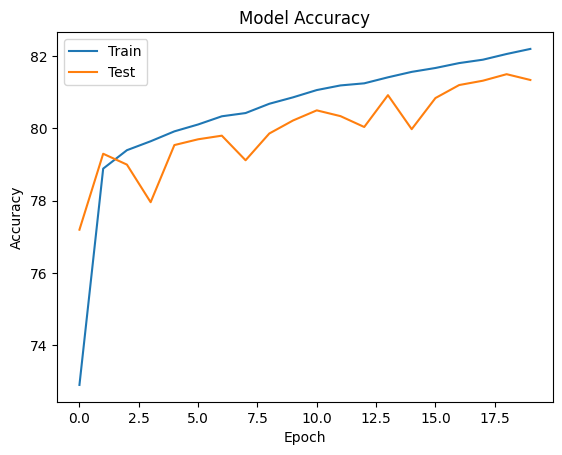

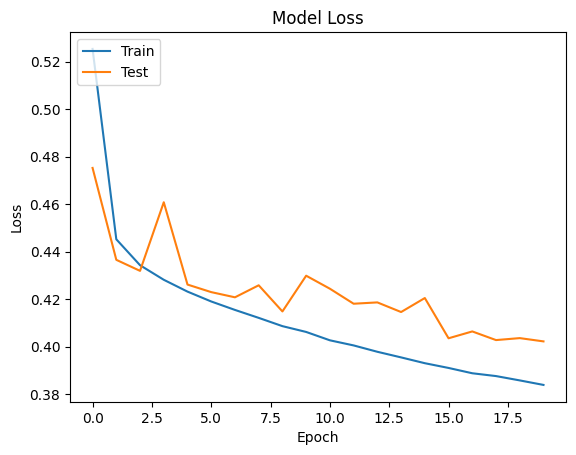

In [ ]:
     #@title Model metrics history
     # summarize history for accuracy
     plt.plot(train_accs)
     plt.plot(val_accs)
     plt.title('Model Accuracy')
     plt.ylabel('Accuracy')
     plt.xlabel('Epoch')
     plt.legend(['Train', 'Test'], loc='upper left')
     plt.show()
     # summarize history for loss
     plt.plot(train_losses)
     plt.plot(val_losses)
     plt.title('Model Loss')
     plt.ylabel('Loss')
     plt.xlabel('Epoch')
     plt.legend(['Train', 'Test'], loc='upper left')
     plt.show()

In [ ]:
torch.save(model_state_dicts, "My-Model_Main.pt")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Inference

In [ ]:
#@title inference
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

def remove_blank_spaces(text):
    text = text.replace(" ", "")
    return text

def remove_url(text):
    """Remove URLs from text"""
    return re.sub(r'http\S+', '', text)

def uniNormalize(text):
    """Normalize unicode characters"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def handle_emoji(text):
    emojis = demoji.findall(text)
    return " ".join([emojis[emoji].split(":")[0] for emoji in emojis]) if emojis else text

def remove_stop_words(tokens):
    """Remove stop words from tokens"""
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]

def lowercase_words(tokens):
    """Convert all tokens to lowercase"""
    return [token.lower() for token in tokens]

def remove_punctuation(text):
    """Remove punctuation from text"""
    text = ' '.join(text)
    return text.translate(str.maketrans('', '', string.punctuation))

def lemmatize_words(words):
    text = "".join(words)
    token = nlp(text)
    text = [word.lemma_ for word in token]
    return text


def preprocessing(text):
    text = remove_url(text)
    text = uniNormalize(text)
    text = handle_emoji(text)
    text = nltk.word_tokenize(text)
    text = remove_stop_words(text)
    text = lowercase_words(text)
    text = remove_punctuation(text)
    text = re.sub(r'[^\w\s]', '', text)
    print(text)
    text = lemmatize_words(text)
    text = " ".join(text)

    return text

def numericalize(text):
    numerialized_source = []
    numerialized_source = [dataset.source_vocab.stoi["<SOS>"]]
    numerialized_source += dataset.source_vocab.numericalize(text)
    numerialized_source.append(dataset.source_vocab.stoi["<EOS>"])
    return numerialized_source

def padding(source):
    padded_sequence = torch.zeros(config.MAX_LEN, 1, dtype = torch.int)
    source = torch.tensor(source)
    if len(source) > config.MAX_LEN:
        padded_sequence[:, 0] = source[: config.MAX_LEN]
    else:
        padded_sequence[:len(source), 0] = padded_sequence[:len(source), 0] + source
    return padded_sequence

def infer_processing(text):
    text = preprocessing(text)
    text = numericalize(text)
    text = padding(text)
    return text

aspects = ["service", "food","location","order","price","staff","menu","experience","taste","drink"]

def get_similarity(text, aspect):
    try:
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0

def best_aspect(text, aspects):
    a = []

    for aspect in aspects:
        a.append(get_similarity(text, aspect))
        print(text, aspect)
    return aspects[np.argmax(a)]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Load brasão review dataframe from drive
drive.mount('/content/gdrive', force_remount=True)

df = pd.read_csv('/content/datasetreview.csv')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/gdrive


In [ ]:
#@title Get Sentiment and Aspects from reviews
def get_sentiment_and_aspect(review):
    ba = best_aspect(preprocessing(review), aspects)
    a = infer_processing(review).to(config.DEVICE)
    model.eval()
    sentiment = model(a)
    sentiment = sentiment.cpu().detach().numpy()[0]
    if sentiment > 0.5:
        sentiment = 'Positively'
    else:
        sentiment = 'Negatively'
    return pd.Series([sentiment, ba])

df[['sentiment', 'aspect']] = df['textTranslated'].apply(get_sentiment_and_aspect)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
the food delicious   space rustic welcome   staff impeccable order
the food delicious   space rustic welcome   staff impeccable price
the food delicious   space rustic welcome   staff impeccable staff
the food delicious   space rustic welcome   staff impeccable menu
the food delicious   space rustic welcome   staff impeccable experience
the food delicious   space rustic welcome   staff impeccable taste
the food delicious   space rustic welcome   staff impeccable drink
the food delicious  space rustic welcoming  staff impeccable 
we wanted try francesinha  site 10 10  problem came asking fills lot  i recommend asking less repeat 
we want try francesinha   site 10 10   problem come ask fill lot   I recommend ask less repeat service
we want try francesinha   site 10 10   problem come ask fill lot   I recommend ask less repeat food
we want try francesinha   site 10 10   problem come ask fill lot   I recommend ask less repeat location
we wa

In [ ]:
df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,city,isLocalGuide,location/lat,location/lng,peopleAlsoSearch/0/title,textTranslated,title,totalScore,sentiment,aspect
0,Porto,True,41.162658,-8.590453,Brasão Aliados,I really liked the concept and the service was...,Brasão Antas,4.6,Negatively,service
1,Porto,True,41.162658,-8.590453,Brasão Aliados,Good food and very well attended. Thanks Arthur!!,Brasão Antas,4.6,Positively,location
2,Porto,True,41.162658,-8.590453,Brasão Aliados,Great experience. Quality service; very nice t...,Brasão Antas,4.6,Positively,service
3,Porto,False,41.162658,-8.590453,Brasão Aliados,"At Brasão we were very well attended by Lucas,...",Brasão Antas,4.6,Positively,service
4,Porto,False,41.162658,-8.590453,Brasão Aliados,Very nice dinner on the terrace! Thanks Tyrone...,Brasão Antas,4.6,Positively,experience
...,...,...,...,...,...,...,...,...,...,...
11122,Porto,False,41.149154,-8.611788,Brasão Salgueiros,"I went with my girl, without a reservation and...",Brasão Aliados,4.6,Positively,service
11123,Porto,True,41.149154,-8.611788,Brasão Salgueiros,Very good meats and Alentejo wine,Brasão Aliados,4.6,Positively,experience
11124,Porto,False,41.149154,-8.611788,Brasão Salgueiros,"Very good place to eat, you have to come early...",Brasão Aliados,4.6,Positively,service
11125,Porto,False,41.149154,-8.611788,Brasão Salgueiros,Very good. The best francesinha!,Brasão Aliados,4.6,Positively,service


In [ ]:
dfyelp.to_csv('/content/gdrive/MyDrive/ISEP/Projeto3/reviewssentimentaspect.csv',index=False)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Load brasão review dataframe from drive
drive.mount('/content/gdrive', force_remount=True)

df = pd.read_csv('/content/gdrive/MyDrive/ISEP/Projeto3/reviewssentimentaspect.csv')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/gdrive


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


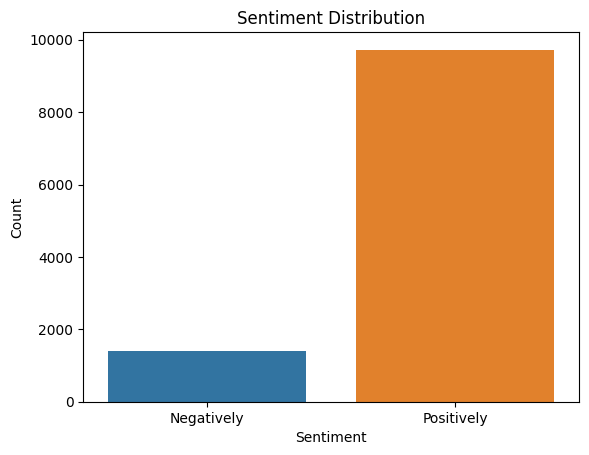

In [ ]:
#@title Creating Graphs to analyze results
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


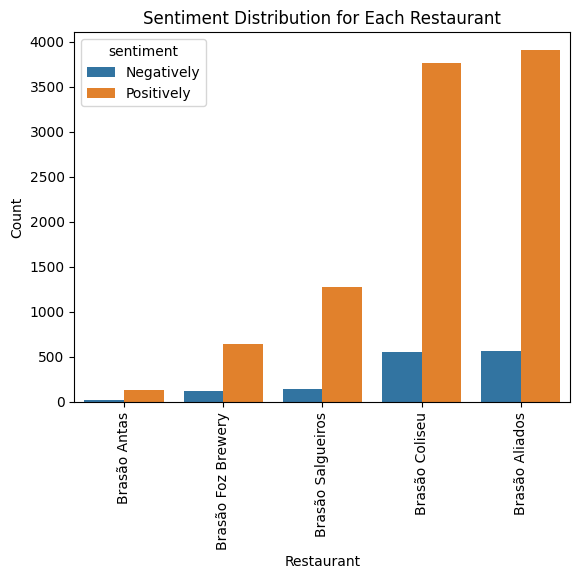

In [ ]:
import seaborn as sns

# create a countplot of the sentiment distribution for each restaurant
sns.countplot(data=df, x='title', hue='sentiment')
plt.xticks(rotation=90)
plt.title('Sentiment Distribution for Each Restaurant')
plt.xlabel('Restaurant')
plt.ylabel('Count')
plt.show()


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


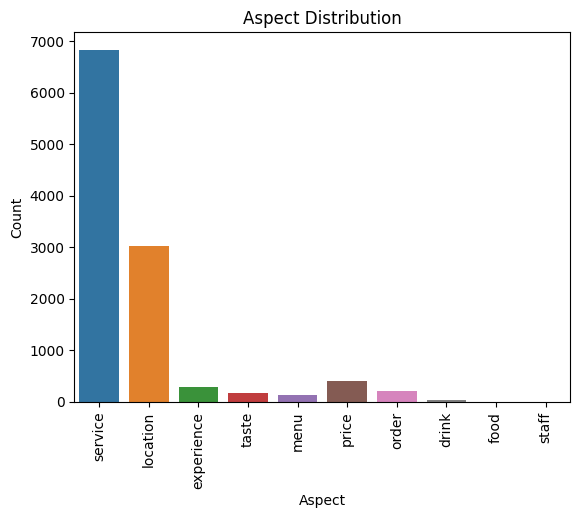

In [ ]:
aspect_map = {'price': 1, 'food': 2, 'service': 3, 'atmosphere': 4}
df['aspect_num'] = df['aspect'].map(aspect_map)

sns.countplot(data=df, x='aspect')
plt.xticks(rotation=90)
plt.title('Aspect Distribution')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


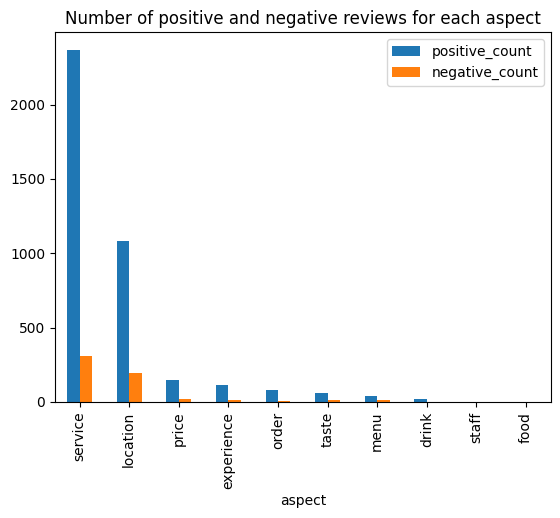

In [ ]:
restaurant_df = df[df['title'] == "Brasão Aliados"]

positive_df = restaurant_df[restaurant_df["sentiment"] == "Positively"][["aspect"]]
negative_df = restaurant_df[restaurant_df["sentiment"] == "Negatively"][["aspect"]]

positive_count = positive_df.groupby("aspect").size().reset_index(name="positive_count")
negative_count = negative_df.groupby("aspect").size().reset_index(name="negative_count")

merged_df = pd.merge(positive_count, negative_count, on="aspect", how="outer").sort_values(by="positive_count", ascending=False)
merged_df.plot(x="aspect", y=["positive_count", "negative_count"], kind="bar")
plt.title("Number of positive and negative reviews for each aspect")
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


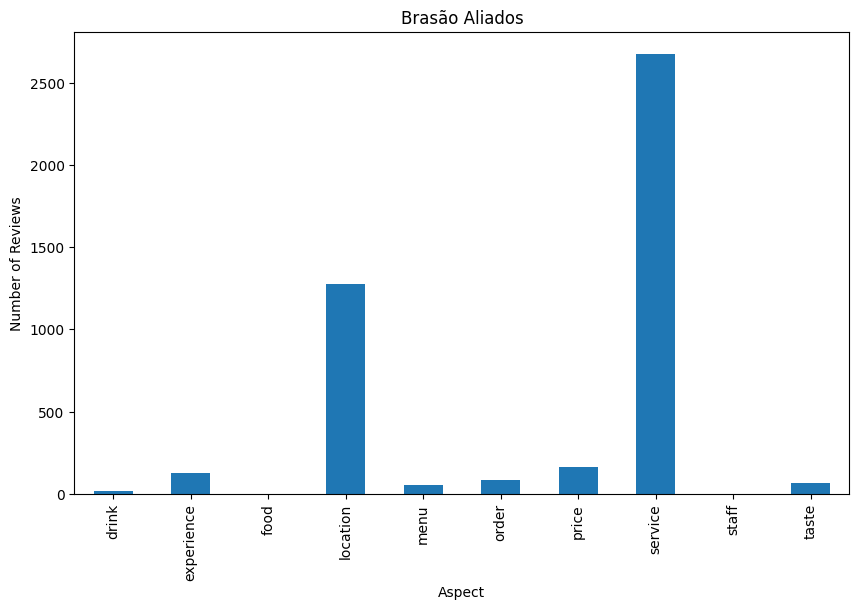

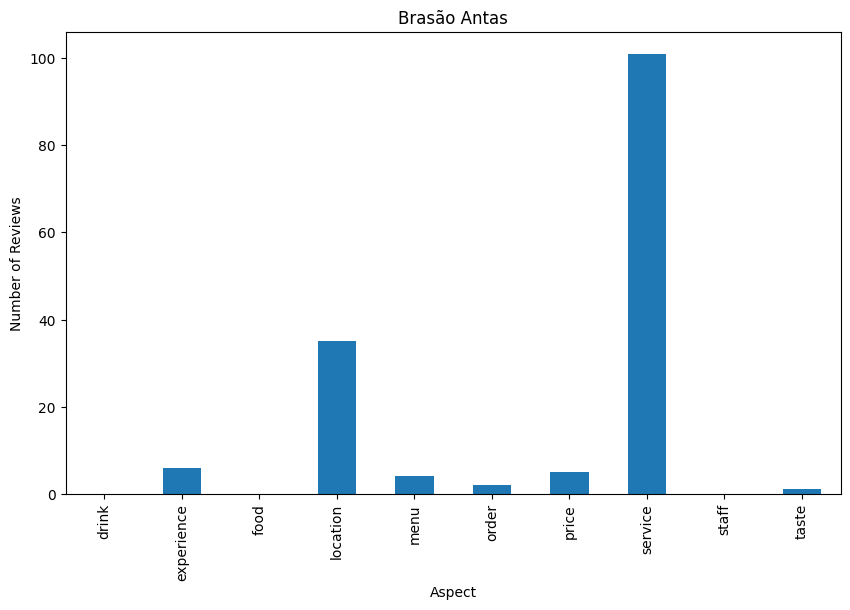

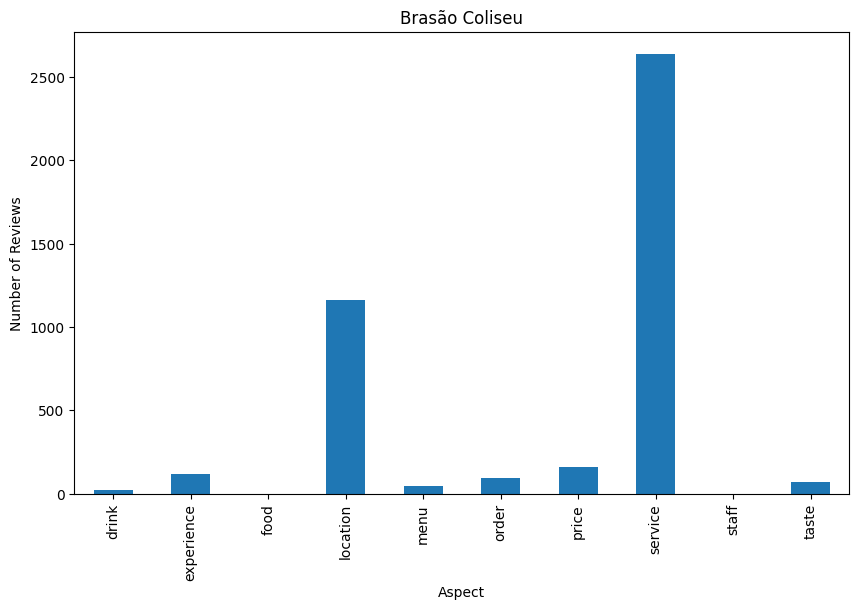

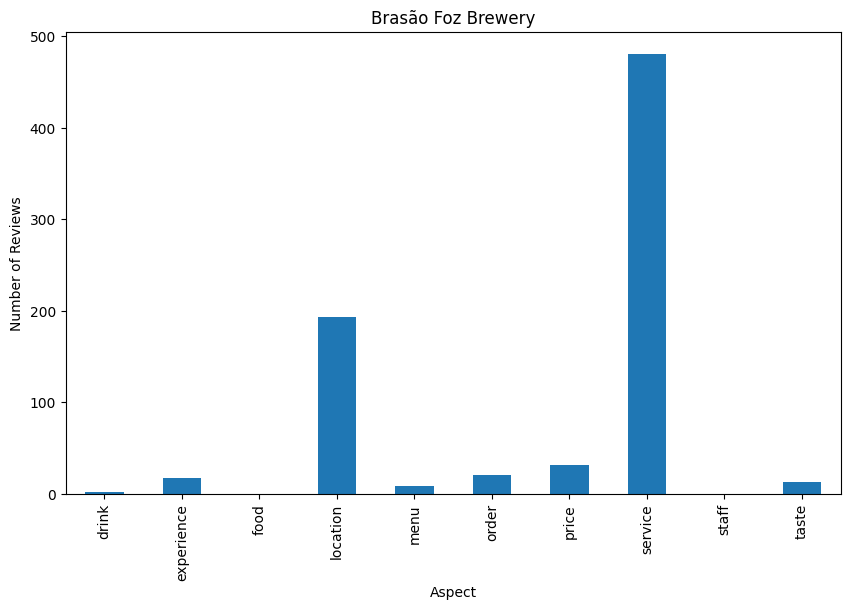

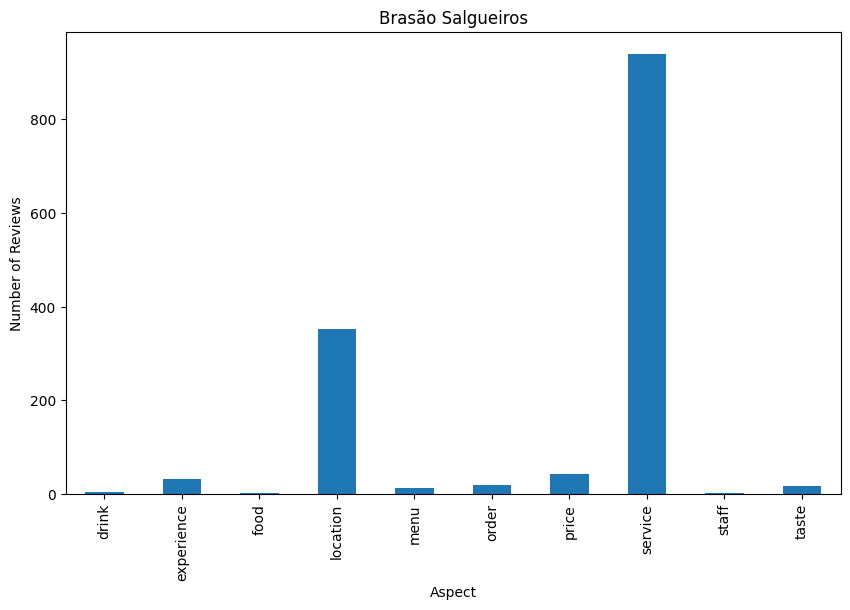

In [ ]:
grouped = df.groupby(['title', 'aspect']).count()['textTranslated'].unstack()

# Plot a stacked bar chart for each restaurant
for restaurant in grouped.index:
    ax = grouped.loc[restaurant].plot(kind='bar', stacked=True, figsize=(10, 6), title=restaurant)
    ax.set_xlabel('Aspect')
    ax.set_ylabel('Number of Reviews')
    plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


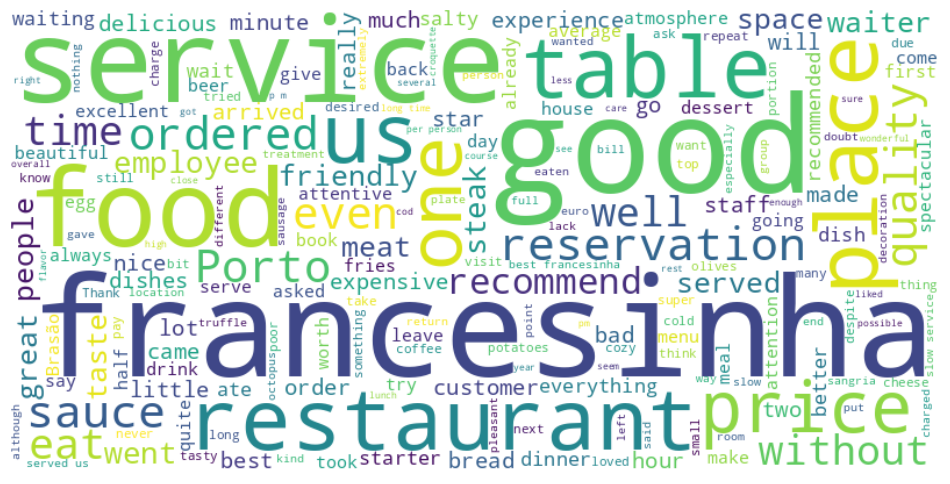

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_service = df[(df["sentiment"] == "Negatively") & (df["aspect"] == "service")]

text = " ".join(negative_service["textTranslated"])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


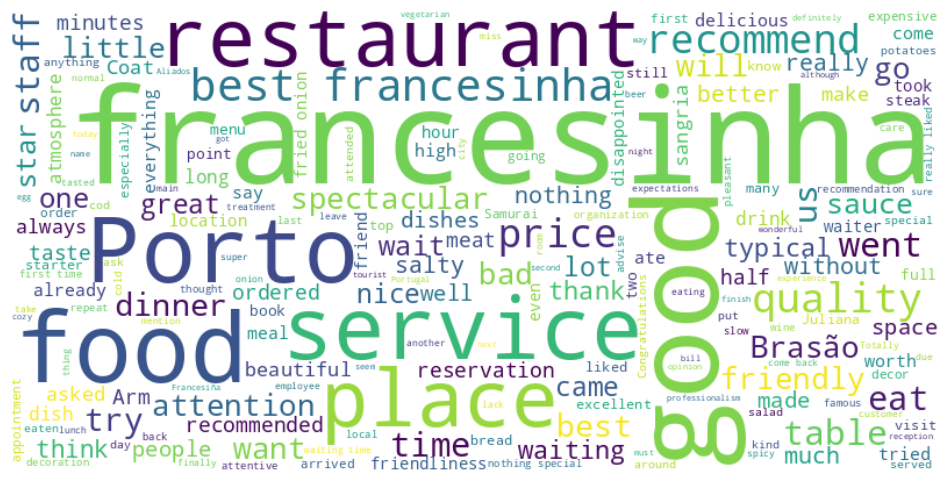

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_service = df[(df["sentiment"] == "Negatively") & (df["aspect"] == "location")]

text = " ".join(negative_service["textTranslated"])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


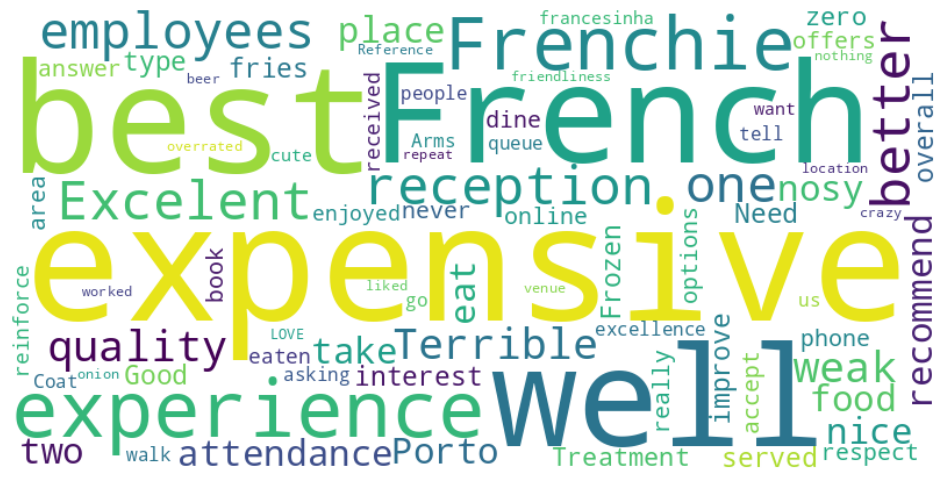

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_service = df[(df["sentiment"] == "Negatively") & (df["aspect"] == "experience")]

text = " ".join(negative_service["textTranslated"])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


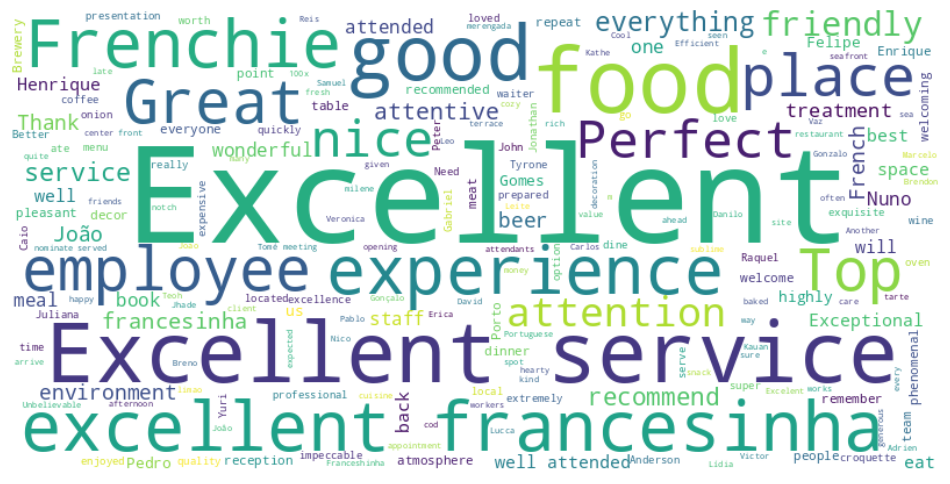

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_service = df[(df["sentiment"] == "Positively") & (df["aspect"] == "experience")]

text = " ".join(negative_service["textTranslated"])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


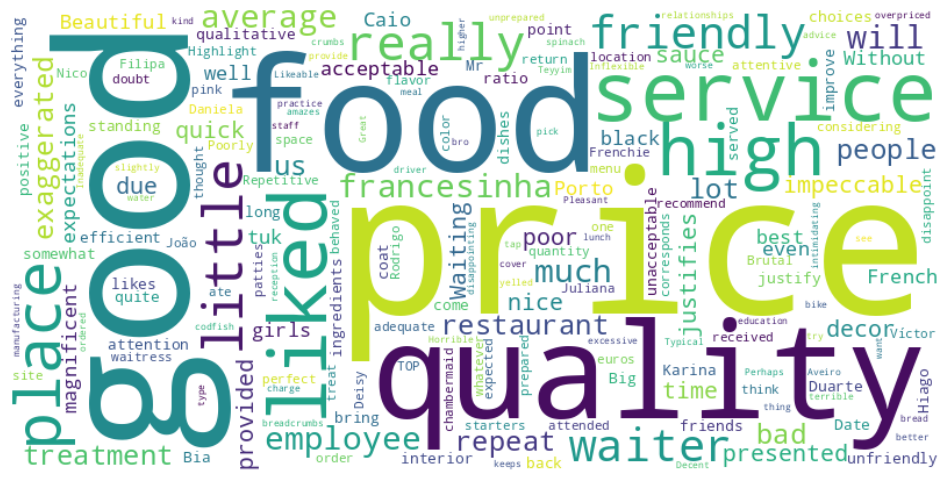

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_service = df[(df["sentiment"] == "Negatively") & (df["aspect"] == "price")]

text = " ".join(negative_service["textTranslated"])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Model Parameters Testing

In [ ]:
#@title Test 1

FOLDS = 20
SHUFFLE = True # randomize the values to increase the fitting
BATCH_SIZE = 64
LR = 0.1
EPOCHS = 20
EMB_DIM = 100
MAX_LEN = 20
DROPOUT = 0.5
HIDDEN_DIM = 128

100%|██████████| 1485/1485 [00:59<00:00, 24.78it/s]
| Train Loss : 0.5704 | Val Loss : 0.5160 | Train Acc : 69.57% | Val Acc : 74.93% |
100%|██████████| 1485/1485 [00:58<00:00, 25.48it/s]
| Train Loss : 0.4532 | Val Loss : 0.4628 | Train Acc : 78.47% | Val Acc : 78.26% |
100%|██████████| 1485/1485 [00:58<00:00, 25.52it/s]
| Train Loss : 0.4382 | Val Loss : 0.4704 | Train Acc : 79.23% | Val Acc : 76.84% |
100%|██████████| 1485/1485 [00:58<00:00, 25.34it/s]
| Train Loss : 0.4327 | Val Loss : 0.4306 | Train Acc : 79.46% | Val Acc : 79.38% |
100%|██████████| 1485/1485 [00:57<00:00, 25.64it/s]
| Train Loss : 0.4275 | Val Loss : 0.4279 | Train Acc : 79.62% | Val Acc : 79.58% |
100%|██████████| 1485/1485 [00:58<00:00, 25.18it/s]
| Train Loss : 0.4245 | Val Loss : 0.4376 | Train Acc : 79.88% | Val Acc : 79.60% |
100%|██████████| 1485/1485 [00:57<00:00, 25.82it/s]
| Train Loss : 0.4222 | Val Loss : 0.4356 | Train Acc : 79.93% | Val Acc : 79.06% |
100%|██████████| 1485/1485 [00:58<00:00, 25.29it/s]
| Train Loss : 0.4202 | Val Loss : 0.4274 | Train Acc : 80.10% | Val Acc : 79.76% |
100%|██████████| 1485/1485 [00:58<00:00, 25.50it/s]
| Train Loss : 0.4168 | Val Loss : 0.4222 | Train Acc : 80.28% | Val Acc : 79.60% |
100%|██████████| 1485/1485 [00:57<00:00, 25.73it/s]
| Train Loss : 0.4146 | Val Loss : 0.4317 | Train Acc : 80.35% | Val Acc : 79.64% |
100%|██████████| 1485/1485 [00:58<00:00, 25.25it/s]
| Train Loss : 0.4118 | Val Loss : 0.4247 | Train Acc : 80.56% | Val Acc : 79.28% |
100%|██████████| 1485/1485 [00:57<00:00, 25.67it/s]
| Train Loss : 0.4096 | Val Loss : 0.4274 | Train Acc : 80.76% | Val Acc : 79.52% |
100%|██████████| 1485/1485 [00:58<00:00, 25.59it/s]
| Train Loss : 0.4073 | Val Loss : 0.4165 | Train Acc : 80.85% | Val Acc : 80.20% |
100%|██████████| 1485/1485 [00:57<00:00, 25.68it/s]
| Train Loss : 0.4054 | Val Loss : 0.4121 | Train Acc : 81.08% | Val Acc : 80.50% |
100%|██████████| 1485/1485 [00:57<00:00, 25.90it/s]
| Train Loss : 0.4034 | Val Loss : 0.4150 | Train Acc : 81.06% | Val Acc : 80.10% |
100%|██████████| 1485/1485 [00:59<00:00, 25.09it/s]
| Train Loss : 0.4019 | Val Loss : 0.4104 | Train Acc : 81.14% | Val Acc : 80.54% |
100%|██████████| 1485/1485 [00:58<00:00, 25.55it/s]
| Train Loss : 0.4002 | Val Loss : 0.4232 | Train Acc : 81.25% | Val Acc : 80.04% |
100%|██████████| 1485/1485 [00:59<00:00, 25.15it/s]
| Train Loss : 0.3989 | Val Loss : 0.4095 | Train Acc : 81.37% | Val Acc : 80.50% |
100%|██████████| 1485/1485 [00:57<00:00, 25.78it/s]
| Train Loss : 0.3970 | Val Loss : 0.4251 | Train Acc : 81.34% | Val Acc : 79.94% |
100%|██████████| 1485/1485 [00:59<00:00, 25.13it/s]
| Train Loss : 0.3956 | Val Loss : 0.4073 | Train Acc : 81.54% | Val Acc : 80.60% |

In [ ]:
#@title Test 2

FOLDS = 20
SHUFFLE = True # randomize the values to increase the fitting
BATCH_SIZE = 16
LR = 0.1
EPOCHS = 20
EMB_DIM = 100
MAX_LEN = 20
DROPOUT = 0.5
HIDDEN_DIM = 128

100%|██████████| 5938/5938 [01:18<00:00, 75.73it/s]
| Train Loss : 0.4960 | Val Loss : 0.5800 | Train Acc : 75.17% | Val Acc : 74.31% |
100%|██████████| 5938/5938 [01:18<00:00, 75.39it/s]
| Train Loss : 0.4354 | Val Loss : 0.4374 | Train Acc : 79.44% | Val Acc : 79.76% |
100%|██████████| 5938/5938 [01:18<00:00, 75.54it/s]
| Train Loss : 0.4226 | Val Loss : 0.4324 | Train Acc : 80.11% | Val Acc : 79.78% |
100%|██████████| 5938/5938 [01:19<00:00, 75.05it/s]
| Train Loss : 0.4147 | Val Loss : 0.4355 | Train Acc : 80.47% | Val Acc : 79.26% |
100%|██████████| 5938/5938 [01:19<00:00, 74.84it/s]
| Train Loss : 0.4101 | Val Loss : 0.4192 | Train Acc : 80.74% | Val Acc : 79.30% |
100%|██████████| 5938/5938 [01:17<00:00, 76.28it/s]
| Train Loss : 0.4062 | Val Loss : 0.4329 | Train Acc : 80.91% | Val Acc : 80.20% |
100%|██████████| 5938/5938 [01:17<00:00, 76.16it/s]
| Train Loss : 0.4034 | Val Loss : 0.4105 | Train Acc : 81.10% | Val Acc : 80.62% |
100%|██████████| 5938/5938 [01:19<00:00, 74.56it/s]
| Train Loss : 0.4001 | Val Loss : 0.4116 | Train Acc : 81.31% | Val Acc : 80.78% |
100%|██████████| 5938/5938 [01:19<00:00, 74.26it/s]
| Train Loss : 0.3980 | Val Loss : 0.4127 | Train Acc : 81.47% | Val Acc : 80.18% |
100%|██████████| 5938/5938 [01:21<00:00, 73.13it/s]
| Train Loss : 0.3954 | Val Loss : 0.4099 | Train Acc : 81.52% | Val Acc : 80.56% |
100%|██████████| 5938/5938 [01:19<00:00, 74.46it/s]
| Train Loss : 0.3930 | Val Loss : 0.4046 | Train Acc : 81.68% | Val Acc : 80.76% |
100%|██████████| 5938/5938 [01:21<00:00, 72.71it/s]
| Train Loss : 0.3915 | Val Loss : 0.4092 | Train Acc : 81.73% | Val Acc : 80.40% |
100%|██████████| 5938/5938 [01:21<00:00, 72.67it/s]
| Train Loss : 0.3897 | Val Loss : 0.4169 | Train Acc : 81.81% | Val Acc : 80.42% |
100%|██████████| 5938/5938 [01:19<00:00, 74.37it/s]
| Train Loss : 0.3880 | Val Loss : 0.4070 | Train Acc : 81.95% | Val Acc : 81.08% |
100%|██████████| 5938/5938 [01:17<00:00, 76.26it/s]
| Train Loss : 0.3859 | Val Loss : 0.4125 | Train Acc : 82.06% | Val Acc : 81.06% |
100%|██████████| 5938/5938 [01:17<00:00, 76.48it/s]
| Train Loss : 0.3846 | Val Loss : 0.4014 | Train Acc : 82.16% | Val Acc : 81.34% |
100%|██████████| 5938/5938 [01:18<00:00, 75.18it/s]
| Train Loss : 0.3831 | Val Loss : 0.4068 | Train Acc : 82.17% | Val Acc : 80.66% |
100%|██████████| 5938/5938 [01:17<00:00, 76.50it/s]
| Train Loss : 0.3814 | Val Loss : 0.4104 | Train Acc : 82.30% | Val Acc : 80.24% |
100%|██████████| 5938/5938 [01:17<00:00, 76.85it/s]
| Train Loss : 0.3795 | Val Loss : 0.4220 | Train Acc : 82.43% | Val Acc : 79.78% |
100%|██████████| 5938/5938 [01:19<00:00, 74.67it/s]
| Train Loss : 0.3776 | Val Loss : 0.4009 | Train Acc : 82.57% | Val Acc : 81.84% |


In [ ]:
#@title Test 3
FOLDS = 20
SHUFFLE = True # randomize the values to increase the fitting
BATCH_SIZE = 32
LR = 0.1
EPOCHS = 20
EMB_DIM = 100
MAX_LEN = 20
DROPOUT = 0.5
HIDDEN_DIM = 128

usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 2969/2969 [01:07<00:00, 44.21it/s]
| Train Loss : 0.5215 | Val Loss : 0.5010 | Train Acc : 73.42% | Val Acc : 77.00% |
100%|██████████| 2969/2969 [01:06<00:00, 44.50it/s]
| Train Loss : 0.4429 | Val Loss : 0.4587 | Train Acc : 78.97% | Val Acc : 78.54% |
100%|██████████| 2969/2969 [01:07<00:00, 43.81it/s]
| Train Loss : 0.4317 | Val Loss : 0.4271 | Train Acc : 79.47% | Val Acc : 79.76% |
100%|██████████| 2969/2969 [01:06<00:00, 44.37it/s]
| Train Loss : 0.4263 | Val Loss : 0.4250 | Train Acc : 79.84% | Val Acc : 79.60% |
100%|██████████| 2969/2969 [01:04<00:00, 46.02it/s]
| Train Loss : 0.4204 | Val Loss : 0.4363 | Train Acc : 79.99% | Val Acc : 79.30% |
100%|██████████| 2969/2969 [01:05<00:00, 45.46it/s]
| Train Loss : 0.4166 | Val Loss : 0.4197 | Train Acc : 80.30% | Val Acc : 80.02% |
100%|██████████| 2969/2969 [01:05<00:00, 45.05it/s]
| Train Loss : 0.4119 | Val Loss : 0.4175 | Train Acc : 80.58% | Val Acc : 80.36% |
100%|██████████| 2969/2969 [01:05<00:00, 45.05it/s]
| Train Loss : 0.4089 | Val Loss : 0.4172 | Train Acc : 80.73% | Val Acc : 80.10% |
100%|██████████| 2969/2969 [01:04<00:00, 46.35it/s]
| Train Loss : 0.4057 | Val Loss : 0.4128 | Train Acc : 80.95% | Val Acc : 80.04% |
100%|██████████| 2969/2969 [01:06<00:00, 44.64it/s]
| Train Loss : 0.4031 | Val Loss : 0.4194 | Train Acc : 80.99% | Val Acc : 80.12% |
100%|██████████| 2969/2969 [01:04<00:00, 45.76it/s]
| Train Loss : 0.4002 | Val Loss : 0.4102 | Train Acc : 81.18% | Val Acc : 80.50% |
100%|██████████| 2969/2969 [01:04<00:00, 45.89it/s]
| Train Loss : 0.3984 | Val Loss : 0.4194 | Train Acc : 81.30% | Val Acc : 79.60% |
100%|██████████| 2969/2969 [01:04<00:00, 45.69it/s]
| Train Loss : 0.3961 | Val Loss : 0.4287 | Train Acc : 81.44% | Val Acc : 78.56% |
100%|██████████| 2969/2969 [01:04<00:00, 45.80it/s]
| Train Loss : 0.3951 | Val Loss : 0.4196 | Train Acc : 81.52% | Val Acc : 80.38% |
100%|██████████| 2969/2969 [01:05<00:00, 45.30it/s]
| Train Loss : 0.3928 | Val Loss : 0.4142 | Train Acc : 81.50% | Val Acc : 80.04% |
100%|██████████| 2969/2969 [01:05<00:00, 45.05it/s]
| Train Loss : 0.3915 | Val Loss : 0.4137 | Train Acc : 81.75% | Val Acc : 80.18% |
100%|██████████| 2969/2969 [01:07<00:00, 44.14it/s]
| Train Loss : 0.3895 | Val Loss : 0.4067 | Train Acc : 81.78% | Val Acc : 80.78% |
100%|██████████| 2969/2969 [01:06<00:00, 44.98it/s]
| Train Loss : 0.3882 | Val Loss : 0.4047 | Train Acc : 81.89% | Val Acc : 80.72% |
100%|██████████| 2969/2969 [01:04<00:00, 46.13it/s]
| Train Loss : 0.3866 | Val Loss : 0.4042 | Train Acc : 81.95% | Val Acc : 81.52% |
100%|██████████| 2969/2969 [01:04<00:00, 45.91it/s]
| Train Loss : 0.3855 | Val Loss : 0.4055 | Train Acc : 81.99% | Val Acc : 81.06% |

In [ ]:
#@title Test 4
FOLDS = 20
SHUFFLE = True # randomize the values to increase the fitting
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 20
EMB_DIM = 100
MAX_LEN = 20
DROPOUT = 0.5
HIDDEN_DIM = 128


    100%|██████████| 2969/2969 [01:10<00:00, 41.82it/s]
| Train Loss : 0.6929 | Val Loss : 0.6925 | Train Acc : 50.71% | Val Acc : 51.85% |
100%|██████████| 2969/2969 [01:08<00:00, 43.10it/s]
| Train Loss : 0.6923 | Val Loss : 0.6921 | Train Acc : 53.59% | Val Acc : 54.49% |
100%|██████████| 2969/2969 [01:08<00:00, 43.11it/s]
| Train Loss : 0.6918 | Val Loss : 0.6916 | Train Acc : 58.81% | Val Acc : 59.49% |
100%|██████████| 2969/2969 [01:07<00:00, 43.84it/s]
| Train Loss : 0.6913 | Val Loss : 0.6911 | Train Acc : 60.13% | Val Acc : 60.45% |
100%|██████████| 2969/2969 [01:06<00:00, 44.43it/s]
| Train Loss : 0.6908 | Val Loss : 0.6906 | Train Acc : 60.67% | Val Acc : 61.09% |
100%|██████████| 2969/2969 [01:09<00:00, 42.69it/s]
| Train Loss : 0.6902 | Val Loss : 0.6900 | Train Acc : 61.57% | Val Acc : 61.39% |
100%|██████████| 2969/2969 [01:08<00:00, 43.62it/s]
| Train Loss : 0.6895 | Val Loss : 0.6893 | Train Acc : 62.07% | Val Acc : 61.81% |
100%|██████████| 2969/2969 [01:09<00:00, 42.48it/s]
| Train Loss : 0.6887 | Val Loss : 0.6885 | Train Acc : 62.44% | Val Acc : 61.93% |
100%|██████████| 2969/2969 [01:10<00:00, 42.26it/s]
| Train Loss : 0.6878 | Val Loss : 0.6876 | Train Acc : 62.76% | Val Acc : 62.07% |
100%|██████████| 2969/2969 [01:09<00:00, 42.74it/s]
| Train Loss : 0.6868 | Val Loss : 0.6865 | Train Acc : 62.69% | Val Acc : 61.97% |
100%|██████████| 2969/2969 [01:10<00:00, 41.94it/s]
| Train Loss : 0.6856 | Val Loss : 0.6852 | Train Acc : 63.17% | Val Acc : 62.15% |
100%|██████████| 2969/2969 [01:09<00:00, 42.94it/s]
| Train Loss : 0.6841 | Val Loss : 0.6837 | Train Acc : 63.21% | Val Acc : 62.59% |
100%|██████████| 2969/2969 [01:10<00:00, 42.10it/s]
| Train Loss : 0.6823 | Val Loss : 0.6818 | Train Acc : 63.52% | Val Acc : 62.91% |
100%|██████████| 2969/2969 [01:06<00:00, 44.58it/s]
| Train Loss : 0.6800 | Val Loss : 0.6794 | Train Acc : 63.90% | Val Acc : 62.91% |
100%|██████████| 2969/2969 [01:05<00:00, 45.54it/s]
| Train Loss : 0.6772 | Val Loss : 0.6764 | Train Acc : 64.02% | Val Acc : 63.35% |
100%|██████████| 2969/2969 [01:06<00:00, 44.96it/s]
| Train Loss : 0.6736 | Val Loss : 0.6725 | Train Acc : 64.39% | Val Acc : 63.49% |
100%|██████████| 2969/2969 [01:06<00:00, 44.46it/s]
| Train Loss : 0.6689 | Val Loss : 0.6673 | Train Acc : 64.71% | Val Acc : 63.99% |
100%|██████████| 2969/2969 [01:07<00:00, 43.94it/s]
| Train Loss : 0.6626 | Val Loss : 0.6605 | Train Acc : 65.07% | Val Acc : 64.71% |
100%|██████████| 2969/2969 [01:07<00:00, 43.76it/s]
| Train Loss : 0.6538 | Val Loss : 0.6508 | Train Acc : 65.72% | Val Acc : 65.29% |
100%|██████████| 2969/2969 [01:07<00:00, 44.06it/s]
| Train Loss : 0.6410 | Val Loss : 0.6360 | Train Acc : 66.57% | Val Acc : 66.17% |

In [ ]:
#@title Test 5
FOLDS = 20
SHUFFLE = True # randomize the values to increase the fitting
BATCH_SIZE = 32
LR = 0.01
EPOCHS = 20
EMB_DIM = 100
MAX_LEN = 20
DROPOUT = 0.5
HIDDEN_DIM = 128


100%|██████████| 2969/2969 [01:05<00:00, 45.01it/s]
| Train Loss : 0.6906 | Val Loss : 0.6877 | Train Acc : 57.85% | Val Acc : 61.85% |
100%|██████████| 2969/2969 [01:06<00:00, 44.48it/s]
| Train Loss : 0.6754 | Val Loss : 0.6505 | Train Acc : 63.44% | Val Acc : 65.73% |
100%|██████████| 2969/2969 [01:05<00:00, 45.23it/s]
| Train Loss : 0.5146 | Val Loss : 0.4628 | Train Acc : 74.78% | Val Acc : 78.44% |
100%|██████████| 2969/2969 [01:08<00:00, 43.53it/s]
| Train Loss : 0.4493 | Val Loss : 0.4587 | Train Acc : 79.08% | Val Acc : 78.30% |
100%|██████████| 2969/2969 [01:06<00:00, 44.85it/s]
| Train Loss : 0.4431 | Val Loss : 0.4461 | Train Acc : 79.21% | Val Acc : 78.88% |
100%|██████████| 2969/2969 [01:05<00:00, 45.05it/s]
| Train Loss : 0.4386 | Val Loss : 0.4569 | Train Acc : 79.48% | Val Acc : 77.66% |
100%|██████████| 2969/2969 [01:07<00:00, 43.99it/s]
| Train Loss : 0.4338 | Val Loss : 0.4595 | Train Acc : 79.53% | Val Acc : 78.04% |
100%|██████████| 2969/2969 [01:06<00:00, 44.76it/s]
| Train Loss : 0.4315 | Val Loss : 0.4397 | Train Acc : 79.63% | Val Acc : 78.54% |
100%|██████████| 2969/2969 [01:04<00:00, 45.96it/s]
| Train Loss : 0.4291 | Val Loss : 0.4447 | Train Acc : 79.66% | Val Acc : 78.78% |
100%|██████████| 2969/2969 [01:04<00:00, 45.80it/s]
| Train Loss : 0.4273 | Val Loss : 0.4357 | Train Acc : 79.69% | Val Acc : 78.80% |
100%|██████████| 2969/2969 [01:05<00:00, 45.65it/s]
| Train Loss : 0.4262 | Val Loss : 0.4375 | Train Acc : 79.85% | Val Acc : 79.26% |
100%|██████████| 2969/2969 [01:06<00:00, 44.47it/s]
| Train Loss : 0.4249 | Val Loss : 0.4330 | Train Acc : 79.93% | Val Acc : 79.32% |
100%|██████████| 2969/2969 [01:04<00:00, 46.27it/s]
| Train Loss : 0.4236 | Val Loss : 0.4356 | Train Acc : 79.80% | Val Acc : 79.30% |
100%|██████████| 2969/2969 [01:04<00:00, 45.72it/s]
| Train Loss : 0.4220 | Val Loss : 0.4309 | Train Acc : 79.95% | Val Acc : 79.26% |
100%|██████████| 2969/2969 [01:06<00:00, 44.82it/s]
| Train Loss : 0.4214 | Val Loss : 0.4408 | Train Acc : 80.03% | Val Acc : 79.16% |
100%|██████████| 2969/2969 [01:05<00:00, 45.40it/s]
| Train Loss : 0.4201 | Val Loss : 0.4350 | Train Acc : 80.05% | Val Acc : 78.62% |
100%|██████████| 2969/2969 [01:04<00:00, 46.13it/s]
| Train Loss : 0.4191 | Val Loss : 0.4342 | Train Acc : 80.13% | Val Acc : 79.70% |
100%|██████████| 2969/2969 [01:05<00:00, 45.55it/s]
| Train Loss : 0.4181 | Val Loss : 0.4331 | Train Acc : 80.16% | Val Acc : 78.40% |
100%|██████████| 2969/2969 [01:05<00:00, 45.26it/s]
| Train Loss : 0.4172 | Val Loss : 0.4498 | Train Acc : 80.20% | Val Acc : 78.60% |
100%|██████████| 2969/2969 [01:04<00:00, 46.24it/s]
| Train Loss : 0.4164 | Val Loss : 0.4259 | Train Acc : 80.20% | Val Acc : 79.04% |

In [ ]:
#@title Test 6

FOLDS = 20
SHUFFLE = True # randomize the values to increase the fitting
BATCH_SIZE = 32
LR = 0.1
EPOCHS = 20
EMB_DIM = 100
MAX_LEN = 20
DROPOUT = 0.3
HIDDEN_DIM = 128

100%|██████████| 2969/2969 [01:04<00:00, 45.74it/s]
| Train Loss : 0.5254 | Val Loss : 0.4579 | Train Acc : 72.87% | Val Acc : 77.30% |
100%|██████████| 2969/2969 [01:06<00:00, 44.78it/s]
| Train Loss : 0.4415 | Val Loss : 0.4995 | Train Acc : 79.03% | Val Acc : 76.32% |
100%|██████████| 2969/2969 [01:07<00:00, 43.96it/s]
| Train Loss : 0.4309 | Val Loss : 0.4389 | Train Acc : 79.44% | Val Acc : 79.28% |
100%|██████████| 2969/2969 [01:08<00:00, 43.25it/s]
| Train Loss : 0.4238 | Val Loss : 0.4272 | Train Acc : 79.96% | Val Acc : 79.40% |
100%|██████████| 2969/2969 [01:06<00:00, 44.41it/s]
| Train Loss : 0.4179 | Val Loss : 0.4239 | Train Acc : 80.33% | Val Acc : 79.94% |
100%|██████████| 2969/2969 [01:07<00:00, 44.24it/s]
| Train Loss : 0.4142 | Val Loss : 0.4195 | Train Acc : 80.45% | Val Acc : 80.18% |
100%|██████████| 2969/2969 [01:05<00:00, 45.59it/s]
| Train Loss : 0.4104 | Val Loss : 0.4182 | Train Acc : 80.65% | Val Acc : 79.58% |
100%|██████████| 2969/2969 [01:05<00:00, 45.27it/s]
| Train Loss : 0.4075 | Val Loss : 0.4258 | Train Acc : 80.86% | Val Acc : 80.22% |
100%|██████████| 2969/2969 [01:07<00:00, 44.19it/s]
| Train Loss : 0.4051 | Val Loss : 0.4141 | Train Acc : 81.07% | Val Acc : 80.38% |
100%|██████████| 2969/2969 [01:03<00:00, 46.40it/s]
| Train Loss : 0.4027 | Val Loss : 0.4195 | Train Acc : 81.15% | Val Acc : 79.50% |
100%|██████████| 2969/2969 [01:01<00:00, 48.32it/s]
| Train Loss : 0.4002 | Val Loss : 0.4149 | Train Acc : 81.23% | Val Acc : 80.36% |
100%|██████████| 2969/2969 [00:59<00:00, 50.20it/s]
| Train Loss : 0.3981 | Val Loss : 0.4133 | Train Acc : 81.36% | Val Acc : 79.94% |
100%|██████████| 2969/2969 [01:00<00:00, 48.67it/s]
| Train Loss : 0.3963 | Val Loss : 0.4092 | Train Acc : 81.46% | Val Acc : 80.50% |
100%|██████████| 2969/2969 [01:03<00:00, 46.67it/s]
| Train Loss : 0.3946 | Val Loss : 0.4106 | Train Acc : 81.60% | Val Acc : 80.20% |
100%|██████████| 2969/2969 [01:04<00:00, 46.20it/s]
| Train Loss : 0.3934 | Val Loss : 0.4107 | Train Acc : 81.52% | Val Acc : 80.82% |
100%|██████████| 2969/2969 [01:03<00:00, 46.72it/s]
| Train Loss : 0.3914 | Val Loss : 0.4063 | Train Acc : 81.70% | Val Acc : 80.54% |
100%|██████████| 2969/2969 [01:03<00:00, 46.70it/s]
| Train Loss : 0.3904 | Val Loss : 0.4122 | Train Acc : 81.77% | Val Acc : 80.78% |
100%|██████████| 2969/2969 [01:03<00:00, 46.48it/s]
| Train Loss : 0.3891 | Val Loss : 0.4255 | Train Acc : 81.92% | Val Acc : 79.68% |
100%|██████████| 2969/2969 [01:02<00:00, 47.48it/s]
| Train Loss : 0.3876 | Val Loss : 0.4119 | Train Acc : 81.95% | Val Acc : 80.96% |
100%|██████████| 2969/2969 [01:03<00:00, 46.48it/s]
| Train Loss : 0.3867 | Val Loss : 0.4112 | Train Acc : 82.00% | Val Acc : 80.92% |

In [ ]:
#@title Test 7

FOLDS = 20
SHUFFLE = True # randomize the values to increase the fitting
BATCH_SIZE = 32
LR = 0.1
EPOCHS = 20
EMB_DIM = 100
MAX_LEN = 20
DROPOUT = 0.7
HIDDEN_DIM = 128


100%|██████████| 2969/2969 [01:03<00:00, 46.75it/s]
| Train Loss : 0.5212 | Val Loss : 0.4477 | Train Acc : 73.19% | Val Acc : 78.86% |
100%|██████████| 2969/2969 [01:03<00:00, 46.44it/s]
| Train Loss : 0.4409 | Val Loss : 0.4328 | Train Acc : 79.02% | Val Acc : 79.56% |
100%|██████████| 2969/2969 [01:03<00:00, 46.98it/s]
| Train Loss : 0.4294 | Val Loss : 0.4287 | Train Acc : 79.63% | Val Acc : 79.58% |
100%|██████████| 2969/2969 [01:05<00:00, 45.64it/s]
| Train Loss : 0.4220 | Val Loss : 0.4260 | Train Acc : 79.94% | Val Acc : 79.38% |
100%|██████████| 2969/2969 [01:04<00:00, 46.36it/s]
| Train Loss : 0.4155 | Val Loss : 0.4197 | Train Acc : 80.37% | Val Acc : 80.22% |
100%|██████████| 2969/2969 [01:04<00:00, 46.29it/s]
| Train Loss : 0.4123 | Val Loss : 0.4283 | Train Acc : 80.50% | Val Acc : 80.20% |
100%|██████████| 2969/2969 [01:05<00:00, 45.10it/s]
| Train Loss : 0.4082 | Val Loss : 0.4183 | Train Acc : 80.78% | Val Acc : 80.38% |
100%|██████████| 2969/2969 [01:06<00:00, 44.94it/s]
| Train Loss : 0.4049 | Val Loss : 0.4138 | Train Acc : 80.99% | Val Acc : 80.16% |
100%|██████████| 2969/2969 [01:04<00:00, 46.01it/s]
| Train Loss : 0.4025 | Val Loss : 0.4115 | Train Acc : 81.11% | Val Acc : 80.34% |
100%|██████████| 2969/2969 [01:05<00:00, 45.46it/s]
| Train Loss : 0.3997 | Val Loss : 0.4122 | Train Acc : 81.24% | Val Acc : 79.90% |
100%|██████████| 2969/2969 [01:06<00:00, 44.79it/s]
| Train Loss : 0.3972 | Val Loss : 0.4169 | Train Acc : 81.43% | Val Acc : 80.26% |
100%|██████████| 2969/2969 [01:04<00:00, 46.35it/s]
| Train Loss : 0.3950 | Val Loss : 0.4097 | Train Acc : 81.51% | Val Acc : 80.06% |
100%|██████████| 2969/2969 [01:04<00:00, 45.90it/s]
| Train Loss : 0.3933 | Val Loss : 0.4348 | Train Acc : 81.62% | Val Acc : 78.50% |
100%|██████████| 2969/2969 [01:05<00:00, 45.16it/s]
| Train Loss : 0.3917 | Val Loss : 0.4192 | Train Acc : 81.69% | Val Acc : 80.68% |
100%|██████████| 2969/2969 [01:06<00:00, 44.90it/s]
| Train Loss : 0.3896 | Val Loss : 0.4124 | Train Acc : 81.83% | Val Acc : 79.82% |
100%|██████████| 2969/2969 [01:03<00:00, 46.59it/s]
| Train Loss : 0.3885 | Val Loss : 0.4057 | Train Acc : 81.87% | Val Acc : 80.72% |
100%|██████████| 2969/2969 [01:03<00:00, 46.46it/s]
| Train Loss : 0.3869 | Val Loss : 0.4095 | Train Acc : 82.00% | Val Acc : 80.66% |
100%|██████████| 2969/2969 [01:03<00:00, 46.62it/s]
| Train Loss : 0.3854 | Val Loss : 0.4068 | Train Acc : 82.13% | Val Acc : 80.66% |
100%|██████████| 2969/2969 [01:03<00:00, 46.70it/s]
| Train Loss : 0.3838 | Val Loss : 0.4059 | Train Acc : 82.12% | Val Acc : 80.82% |
100%|██████████| 2969/2969 [01:05<00:00, 45.46it/s]
| Train Loss : 0.3828 | Val Loss : 0.4032 | Train Acc : 82.17% | Val Acc : 81.02% |

In [ ]:
#@title Test 8

FOLDS = 20
SHUFFLE = True # randomize the values to increase the fitting
BATCH_SIZE = 32
LR = 0.1
EPOCHS = 20
EMB_DIM = 100
MAX_LEN = 20
DROPOUT = 0.5
HIDDEN_DIM = 256



#add o resultado aqui
/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------0-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------1-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------2-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------3-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------4-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------5-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------6-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------7-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------8-fold of the model-----------------------------------------------------------
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------9-fold of the model-----------------------------------------------------------
100%|██████████| 2813/2813 [02:30<00:00, 18.67it/s]
| Train Loss : 0.5274 | Val Loss : 0.5256 | Train Acc : 72.87% | Val Acc : 74.56% |
100%|██████████| 2813/2813 [02:27<00:00, 19.12it/s]
| Train Loss : 0.4448 | Val Loss : 0.4495 | Train Acc : 78.96% | Val Acc : 78.48% |
100%|██████████| 2813/2813 [02:20<00:00, 19.98it/s]
| Train Loss : 0.4350 | Val Loss : 0.4372 | Train Acc : 79.52% | Val Acc : 78.92% |
100%|██████████| 2813/2813 [02:19<00:00, 20.19it/s]
| Train Loss : 0.4285 | Val Loss : 0.4301 | Train Acc : 79.68% | Val Acc : 79.45% |
100%|██████████| 2813/2813 [02:18<00:00, 20.27it/s]
| Train Loss : 0.4239 | Val Loss : 0.4454 | Train Acc : 80.04% | Val Acc : 77.95% |
100%|██████████| 2813/2813 [02:26<00:00, 19.17it/s]
| Train Loss : 0.4200 | Val Loss : 0.4420 | Train Acc : 80.07% | Val Acc : 78.62% |
100%|██████████| 2813/2813 [02:16<00:00, 20.59it/s]
| Train Loss : 0.4165 | Val Loss : 0.4450 | Train Acc : 80.44% | Val Acc : 78.10% |
100%|██████████| 2813/2813 [02:17<00:00, 20.46it/s]
| Train Loss : 0.4133 | Val Loss : 0.4361 | Train Acc : 80.60% | Val Acc : 79.00% |
100%|██████████| 2813/2813 [02:18<00:00, 20.36it/s]
| Train Loss : 0.4103 | Val Loss : 0.4200 | Train Acc : 80.69% | Val Acc : 79.86% |
100%|██████████| 2813/2813 [02:17<00:00, 20.47it/s]
| Train Loss : 0.4075 | Val Loss : 0.4257 | Train Acc : 80.80% | Val Acc : 79.96% |
100%|██████████| 2813/2813 [02:17<00:00, 20.46it/s]
| Train Loss : 0.4045 | Val Loss : 0.4134 | Train Acc : 81.04% | Val Acc : 79.95% |
100%|██████████| 2813/2813 [02:16<00:00, 20.61it/s]
| Train Loss : 0.4022 | Val Loss : 0.4452 | Train Acc : 81.16% | Val Acc : 78.43% |
100%|██████████| 2813/2813 [02:15<00:00, 20.71it/s]
| Train Loss : 0.3999 | Val Loss : 0.4166 | Train Acc : 81.26% | Val Acc : 79.71% |
100%|██████████| 2813/2813 [02:15<00:00, 20.70it/s]
| Train Loss : 0.3975 | Val Loss : 0.4176 | Train Acc : 81.40% | Val Acc : 79.43% |
100%|██████████| 2813/2813 [02:15<00:00, 20.76it/s]
| Train Loss : 0.3961 | Val Loss : 0.4087 | Train Acc : 81.49% | Val Acc : 80.29% |
100%|██████████| 2813/2813 [02:16<00:00, 20.67it/s]
| Train Loss : 0.3946 | Val Loss : 0.4080 | Train Acc : 81.65% | Val Acc : 80.60% |
100%|██████████| 2813/2813 [02:17<00:00, 20.41it/s]
| Train Loss : 0.3931 | Val Loss : 0.4106 | Train Acc : 81.74% | Val Acc : 79.97% |
100%|██████████| 2813/2813 [02:16<00:00, 20.53it/s]
| Train Loss : 0.3924 | Val Loss : 0.4120 | Train Acc : 81.69% | Val Acc : 80.42% |
100%|██████████| 2813/2813 [02:15<00:00, 20.82it/s]
| Train Loss : 0.3907 | Val Loss : 0.4149 | Train Acc : 81.90% | Val Acc : 79.97% |
100%|██████████| 2813/2813 [02:15<00:00, 20.82it/s]
| Train Loss : 0.3897 | Val Loss : 0.4286 | Train Acc : 81.85% | Val Acc : 80.07% |
100%|██████████| 2813/2813 [02:16<00:00, 20.67it/s]
| Train Loss : 0.3885 | Val Loss : 0.4066 | Train Acc : 81.95% | Val Acc : 80.53% |
100%|██████████| 2813/2813 [02:15<00:00, 20.69it/s]
| Train Loss : 0.3878 | Val Loss : 0.4065 | Train Acc : 81.90% | Val Acc : 80.52% |
100%|██████████| 2813/2813 [02:17<00:00, 20.43it/s]
| Train Loss : 0.3862 | Val Loss : 0.4186 | Train Acc : 82.08% | Val Acc : 80.51% |
100%|██████████| 2813/2813 [02:16<00:00, 20.64it/s]
| Train Loss : 0.3858 | Val Loss : 0.4164 | Train Acc : 82.18% | Val Acc : 80.37% |
100%|██████████| 2813/2813 [02:15<00:00, 20.83it/s]
| Train Loss : 0.3844 | Val Loss : 0.4030 | Train Acc : 82.23% | Val Acc : 80.97% |
100%|██████████| 2813/2813 [02:15<00:00, 20.70it/s]
| Train Loss : 0.3836 | Val Loss : 0.4077 | Train Acc : 82.17% | Val Acc : 81.01% |
100%|██████████| 2813/2813 [02:15<00:00, 20.77it/s]
| Train Loss : 0.3828 | Val Loss : 0.4128 | Train Acc : 82.25% | Val Acc : 80.74% |
100%|██████████| 2813/2813 [02:16<00:00, 20.59it/s]
| Train Loss : 0.3819 | Val Loss : 0.4035 | Train Acc : 82.34% | Val Acc : 80.73% |
100%|██████████| 2813/2813 [02:16<00:00, 20.67it/s]
| Train Loss : 0.3805 | Val Loss : 0.4094 | Train Acc : 82.40% | Val Acc : 80.61% |
100%|██████████| 2813/2813 [02:18<00:00, 20.37it/s]
| Train Loss : 0.3794 | Val Loss : 0.4091 | Train Acc : 82.38% | Val Acc : 80.86% |


In [ ]:
#@title Test 9

FOLDS = 20
SHUFFLE = True # randomize the values to increase the fitting
BATCH_SIZE = 32
LR = 0.1
EPOCHS = 20
EMB_DIM = 100
MAX_LEN = 20
DROPOUT = 0.5
HIDDEN_DIM = 512


#add o resultado aqui
100%|██████████| 2969/2969 [07:31<00:00,  6.58it/s]
| Train Loss : 0.5202 | Val Loss : 0.4651 | Train Acc : 73.38% | Val Acc : 77.76% |
100%|██████████| 2969/2969 [07:33<00:00,  6.54it/s]
| Train Loss : 0.4483 | Val Loss : 0.4410 | Train Acc : 79.00% | Val Acc : 79.20% |
100%|██████████| 2969/2969 [07:50<00:00,  6.31it/s]
| Train Loss : 0.4384 | Val Loss : 0.4411 | Train Acc : 79.30% | Val Acc : 79.14% |
100%|██████████| 2969/2969 [07:45<00:00,  6.38it/s]
| Train Loss : 0.4324 | Val Loss : 0.4424 | Train Acc : 79.53% | Val Acc : 79.26% |
100%|██████████| 2969/2969 [07:45<00:00,  6.37it/s]
| Train Loss : 0.4287 | Val Loss : 0.4520 | Train Acc : 79.61% | Val Acc : 79.26% |
100%|██████████| 2969/2969 [07:35<00:00,  6.52it/s]
| Train Loss : 0.4258 | Val Loss : 0.4304 | Train Acc : 79.86% | Val Acc : 79.66% |
100%|██████████| 2969/2969 [07:41<00:00,  6.43it/s]
| Train Loss : 0.4219 | Val Loss : 0.4303 | Train Acc : 80.07% | Val Acc : 78.78% |
100%|██████████| 2969/2969 [07:49<00:00,  6.32it/s]
| Train Loss : 0.4189 | Val Loss : 0.4233 | Train Acc : 80.28% | Val Acc : 79.68% |
100%|██████████| 2969/2969 [07:46<00:00,  6.37it/s]
| Train Loss : 0.4158 | Val Loss : 0.4309 | Train Acc : 80.35% | Val Acc : 78.26% |
100%|██████████| 2969/2969 [07:37<00:00,  6.49it/s]
| Train Loss : 0.4133 | Val Loss : 0.4209 | Train Acc : 80.55% | Val Acc : 79.84% |
100%|██████████| 2969/2969 [07:47<00:00,  6.36it/s]
| Train Loss : 0.4097 | Val Loss : 0.4203 | Train Acc : 80.70% | Val Acc : 79.96% |
100%|██████████| 2969/2969 [07:41<00:00,  6.44it/s]
| Train Loss : 0.4074 | Val Loss : 0.4412 | Train Acc : 80.95% | Val Acc : 79.02% |
100%|██████████| 2969/2969 [07:47<00:00,  6.35it/s]
| Train Loss : 0.4051 | Val Loss : 0.4177 | Train Acc : 81.05% | Val Acc : 79.74% |
100%|██████████| 2969/2969 [07:36<00:00,  6.51it/s]
| Train Loss : 0.4030 | Val Loss : 0.4184 | Train Acc : 81.11% | Val Acc : 80.12% |
100%|██████████| 2969/2969 [07:45<00:00,  6.38it/s]
| Train Loss : 0.4014 | Val Loss : 0.4236 | Train Acc : 81.28% | Val Acc : 80.30% |
100%|██████████| 2969/2969 [07:38<00:00,  6.48it/s]
| Train Loss : 0.3994 | Val Loss : 0.4164 | Train Acc : 81.31% | Val Acc : 79.48% |
100%|██████████| 2969/2969 [07:31<00:00,  6.57it/s]
| Train Loss : 0.3977 | Val Loss : 0.4112 | Train Acc : 81.44% | Val Acc : 80.52% |
100%|██████████| 2969/2969 [07:30<00:00,  6.59it/s]
| Train Loss : 0.3968 | Val Loss : 0.4111 | Train Acc : 81.42% | Val Acc : 80.22% |
100%|██████████| 2969/2969 [07:34<00:00,  6.53it/s]
| Train Loss : 0.3950 | Val Loss : 0.4076 | Train Acc : 81.60% | Val Acc : 80.54% |
100%|██████████| 2969/2969 [07:47<00:00,  6.35it/s]
| Train Loss : 0.3944 | Val Loss : 0.4131 | Train Acc : 81.63% | Val Acc : 80.26% |

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndentationError: ignored